# Experiment organization
Goal: Gather results from all topic modeling experiments using many stemming treatments for a particular corpus, then creates some visualizations.
The expected tree structure for the corpus and experiments is as follows:
```
<corpus> # corpus name - 'tiger','rnc' or 'opencorpora'
├── <corpus>_<stemmer> # stemmer or lemmatization treatment name, see topic_modeling/stemming.py for language details
│   ├── <corpus_oracleAnalysis.gz # Only present when stemmer=='oracle', the annotation labels for the words in the corpus, in sequence to match up with state files
│   ├── <corpus>_<stemmer>.mallet # mallet import-dir --output
│   ├── <corpus>_<stemmer>.tsv # output of topic_modeling/corpus_preprocessing.py for this particular treatment
│   ├── <corpus>_<stemmer>_<num_topics>_topics_<num_iters>_iters_<experiment_id> 
│   │   ├── <corpus>_<stemmer>_diagnostics.tsv # mallet train-topics metrics as tsv
│   │   ├── <corpus>_<stemmer>_diagnostics.xml # original mallet train-topics metrics format
│   │   ├── <corpus>_<stemmer>_doc_topics.txt # mallet train-topics --output-doc-topics 
│   │   ├── <corpus>_<stemmer>_entropy_metrics.tsv # metrics produced by by topic_modeling/mallet_parser slot-entropy
│   │   ├── <corpus>_<stemmer>.model # mallet topic model 
│   │   ├── <corpus>_<stemmer>_postLemmatized_diagnostics.tsv # mallet train-topics metrics for the version of this model lifted to lemmas 
│   │   ├── <corpus>_<stemmer>_postLemmatized_diagnostics.xml 
│   │   ├── <corpus>_<stemmer>_postLemmatized.mallet # mallet corpus sequence file lifted to lemmas (we probably only need to create this once, but I didn't think of that earlier, so for now each experiment gets its own)
│   │   ├── <corpus>_<stemmer>_postLemmatized.model # mallet topic model lifted to lemmas
│   │   ├── <corpus>_<stemmer>_postLemmatized_state.gz # mallet topic model state file lifted to 
│   │   ├── <corpus>_<stemmer>_state.gz # mallet topic model state file
│   │   ├── <corpus>_<stemmer>_top_docs.txt # mallet train-topics --output-doc-topics 
│   │   ├── <corpus>_<stemmer>_topic_keys.txt # mallet train-topics --output-topic-keys
│   │   ├── <corpus>_<stemmer>_topic_lemmas.tsv # Counts and conditional probablilities of lemmas for each topic
│   │   ├── <corpus>_<stemmer>_topic_pos.tsv  # Counts and conditional probablilities of parts-of-speech for each topic
│   │   ├── <corpus>_<stemmer>_topic_slots.tsv  # Counts and conditional probablilities of detailed morphological analyses for each topic
│   │   └── <corpus>_<stemmer>_top_terms.tsv # Raw counts of top 20 terms for each topic
└── voi_<num_topics>_topics # Variation of information between different models for the same number of topics
    └── <corpus>_<stemmer1>_<experiment1_id>_<corpus>_<stemmer2>_<experiment2_id>.tsv # Compares treatment 1 and treatment 2 

```



In [1]:
from pathlib import Path 
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from scipy import stats
from topic_modeling import mallet_parser

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
sns.set_theme(style="white")

In [2]:
def parse_experiment_directory(experiment_path):
    """Parses out all topic level metrics from a topic model's TSV results file, given the model's path. 
    Returns topic level metrics as a dataframe
    """
    dir_name = experiment_path.name
    split_name = dir_name.split("_")
    corpus = split_name[0]
    treatment = split_name[1]
    num_topics = split_name[2]
    experiment_id = split_name[-1]
    original_mallet_diagnostics = pd.read_csv(experiment_path / f"{corpus}_{treatment}_diagnostics.tsv", sep="\t", index_col="id", na_filter=False)

    final_frame = original_mallet_diagnostics
    final_frame['negative_coherence'] = - final_frame['coherence']

    final_frame.insert(loc = 0, column="corpus", value = corpus)
    final_frame.insert(loc = 1, column="treatment", value=treatment)
    final_frame.insert(loc = 2, column="num_topics", value=int(num_topics))
    final_frame.insert(loc = 3, column="experiment_id", value = experiment_id)

    lemma_mallet_diagnostics = pd.read_csv(experiment_path / f"{corpus}_{treatment}_postLemmatized_diagnostics.tsv", sep="\t", index_col="id")
    lemma_mallet_diagnostics.rename(columns = {"exclusivity":"lemma_exclusivity"}, inplace=True)
    
    final_frame["lemma_exclusivity"] = lemma_mallet_diagnostics["lemma_exclusivity"]

    entropy_metrics = pd.read_csv(experiment_path / f"{corpus}_{treatment}_entropy_metrics.tsv", sep = "\t", index_col="topic")

    final_frame = pd.merge(final_frame, entropy_metrics, left_index= True, right_index = True)
    final_frame = final_frame.reset_index().rename(columns={"id":"topic_id"})

    return final_frame

def parse_voi_tsv(voi_tsv):
    """Returns a dataframe for the VOI results in a single VOI tsv output.
    """
    split_name = voi_tsv.name[:-4].split("_")
    stemmer_a = split_name[1]
    a_exp_id = split_name[2]
    stemmer_b = split_name[4]
    b_exp_id = split_name[5]
    voi_frame = pd.read_csv(voi_tsv, sep="\t", index_col=False, names = ["a_path", "b_path", "voi"])
    voi_frame["treatment_a"] = stemmer_a
    voi_frame["a_experiment_id"] = a_exp_id
    voi_frame["treatment_b"] = stemmer_b
    voi_frame["b_experiment_id"] = b_exp_id
    if stemmer_a != stemmer_b:
        # VOI is symmetric, so flip them too
        flipped_df = voi_frame.copy()
        flipped_df["treatment_a"] = stemmer_b
        flipped_df["a_experiment_id"] = b_exp_id
        flipped_df["treatment_b"] = stemmer_a
        flipped_df["b_experiment_id"] = a_exp_id
        voi_frame = pd.concat([voi_frame, flipped_df], ignore_index=True)
    return voi_frame

def parse_voi_directory(voi_path):
    """Parses out all VOI comparisons between experiments from the TSVs in the VOI directory.
    Returns all VOI comparisons as a dataframe
    """
    tsvs = voi_path.glob("*.tsv")
    return pd.concat([parse_voi_tsv(t) for t in tsvs], ignore_index=True, sort=False)

# Corpus stats

In [3]:
corpus_name = "rnc"
corpus_root = Path("/home/virginia/workspace/topic-modeling-study") / corpus_name
experiment_folders = list(corpus_root.glob(f"{corpus_name}_*/*_topics_*_iters_*"))
oracle_gz = corpus_root / f"{corpus_name}_oracle/{corpus_name}_oracleAnalysis.gz"
voi_folders = list(corpus_root.glob("voi_*"))
corpus_stats_tsv = corpus_root / f"{corpus_name}_corpus_stats.tsv"
print("Num experiment folders found:", len(experiment_folders))
print("Oralce gzip path:", oracle_gz)
print("VOI folders:", voi_folders)

# How to order treatments in plots
hue_order = ["raw", "oracle", "pymystem3", "stanza", "snowball", "truncate6", "truncate5"]

Num experiment folders found: 140
Oralce gzip path: /home/virginia/workspace/topic-modeling-study/rnc/rnc_oracle/rnc_oracleAnalysis.gz
VOI folders: [PosixPath('/home/virginia/workspace/topic-modeling-study/rnc/voi_100_topics'), PosixPath('/home/virginia/workspace/topic-modeling-study/rnc/voi_50_topics')]


,treatment,token_count,word_type_count,type_to_token_ratio,char_to_token_ratio
0,raw,7169,79413,11.07730,669.634
1,oracle,8209,32487,3.95749,578.231
2,pymystem3,7166,30614,4.27212,666.617
3,snowball,7179,31048,4.32484,525.106
4,stanza,4484,32760,7.30598,1043.520
5,truncate5,5121,28085,5.48428,601.954
6,truncate6,6336,39386,6.21622,563.072


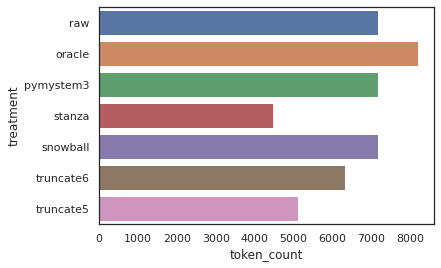

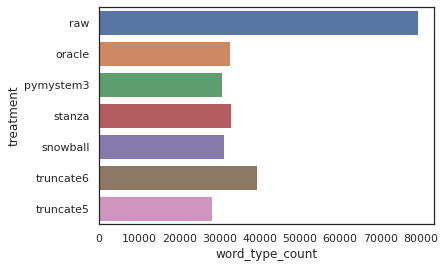

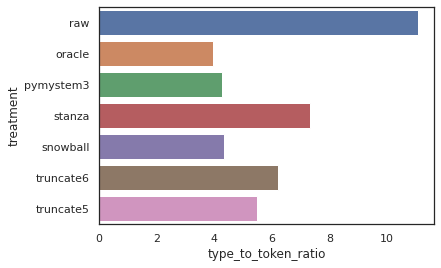

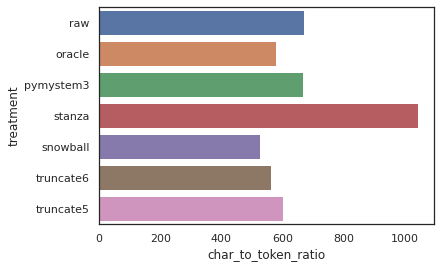

In [4]:
stat_cols = ['token_count', 'word_type_count', 'type_to_token_ratio', 'char_to_token_ratio']
stats_frame = pd.read_csv(corpus_stats_tsv, sep="\t", index_col=False)
display(stats_frame)

for i, c in enumerate(stat_cols):
    plt.figure(i)
    sns.barplot(data = stats_frame, x=c, y="treatment", order=hue_order)

In [5]:
# Concat all experiment results together, save off results
full_frame = pd.concat([parse_experiment_directory(f) for f in experiment_folders], ignore_index=True, sort=False)
print("Total entries:", len(full_frame))
full_frame.to_csv(corpus_root / f'{corpus_name}_all_experiments_metrics.tsv', sep='\t', index=False)
full_frame.head(3)

Total entries: 10500


,topic_id,corpus,treatment,num_topics,experiment_id,tokens,document_entropy,word-length,coherence,uniform_dist,corpus_dist,eff_num_words,token-doc-diff,rank_1_docs,allocation_ratio,allocation_count,exclusivity,negative_coherence,lemma_exclusivity,lemma_entropy,slot_entropy,pos_entropy,lemmas_to_top_20_surface_forms,slots_to_top_20_surface_forms,pos_to_top_20_surface_forms,top_20_term_set,top_20_lemma_set,lemmas_in_top_20_terms,top_lemmas_minus_top_term_lemmas,top_term_lemmas_minus_top_lemmas,num_lemmas_in_top_20_terms,num_top_lemmas_excluded_by_top_terms,num_top_term_lemmas_excluded_by_top_lemmas
0,0,rnc,oracle,50,4,3256.0,2.1802,7.40,-373.1866,4.6041,3.4329,130.1185,0.0461,0.0563,0.0,0.0282,0.5731,373.1866,0.5731,8.335485,6.480768,1.580940,1.0,3.55,0.15,модератор игорь елена человек азербайджан народ образование партия виктор светлана надежда страна интеллигенция культура ii александра русский наука конференция ученый,модератор игорь елена человек азербайджан народ образование партия виктор светлана надежда страна интеллигенция культура ii александра русский наука конференция ученый,модератор игорь елена человек азербайджан народ образование партия виктор светлана надежда страна интеллигенция культура ii александра русский наука конференция ученый,NaN,NaN,20,0,0
1,1,rnc,oracle,50,4,4179.0,2.1633,7.65,-257.0771,4.6067,3.0428,147.1511,0.0146,0.0261,0.0,0.0087,0.4943,257.0771,0.4943,8.331686,6.520180,1.557456,1.0,3.90,0.10,вопрос власть орган правило муниципальный человек должен чиновник взятка самоуправление образование контроль депутат причина проект местный коррупция ресурс население город,вопрос власть орган правило муниципальный человек должен чиновник взятка самоуправление образование контроль депутат причина проект местный коррупция ресурс население город,вопрос власть орган правило муниципальный человек должен чиновник взятка самоуправление образование контроль депутат причина проект местный коррупция ресурс население город,NaN,NaN,20,0,0
2,2,rnc,oracle,50,4,1905.0,2.2760,6.85,-605.7752,4.2815,4.2792,182.5190,0.0482,0.1515,0.0,0.0909,0.8135,605.7752,0.8135,8.800856,6.262607,1.893775,1.0,3.20,0.15,xgi сгибова брэнд жигулевский монах adobe знак куи графический алкогольный пиво самарский оао завод марка ирландия производитель килкенни товарный роспатент,xgi сгибова брэнд жигулевский монах adobe знак куи графический алкогольный пиво самарский оао завод марка ирландия производитель килкенни товарный роспатент,xgi сгибова брэнд жигулевский монах adobe знак куи графический алкогольный пиво самарский оао завод марка ирландия производитель килкенни товарный роспатент,NaN,NaN,20,0,0


In [6]:
num_topics = [50, 100]
num_topics_splits = []
for t in num_topics:
    topic_df = full_frame[full_frame["num_topics"] == t]
    num_topics_splits.append((t, topic_df))

for t, df in num_topics_splits:
    print(t, "topics length:", len(df))



50 topics length: 3500
100 topics length: 7000


# Entropy metrics
Using the annotated corpus as the oracle for lemma, parts of speech and morphological analysis, what's the entropy of topics with respect the original to the grammatical forms of the original wordforms in the documents? 

The treated corpora should have lower lemma entropies, since lemmatiztion forces wordtypes with the same lemma to be together. We would also expect the treated corpora to have higher slot entropy than the raw corpus, because treatments conflate many wordforms with different morphological analyses, but this does not appear to be the case.

- 'raw' has most extreme mean in all cases of entropy metrics - low document entropy & high entropy for grammatical features
- 'raw' (no treatment) has higher lemma and morphological slot entropy than all other treatments. How can the untreated corpus get both higher average lemma entropy and higher average slot entropy? If our expectation is that all forms of a particular lemma concentrate in a given topic (low lemma entropy, high slot entropy), this finding runs counter to that expectation.

In [7]:
# Determine corpus level slot, lemma, pos entropy 
surface_form_counts, lemma_counts, slot_counts, pos_counts = mallet_parser.get_corpus_analysis_counts(oracle_gz)
print("Surface forms vocab size (should match raw vocab size):", len(surface_form_counts), "Sum:", sum(surface_form_counts.values()))
print("Lemma vocab size (should match oracle vocab size):", len(lemma_counts), "Sum:", sum(lemma_counts.values()))
print("Slot vocab size:", len(slot_counts), "Sum:", sum(slot_counts.values()))
print("POS vocab size:", len(pos_counts), "Sum:", sum(pos_counts.values()))

Surface forms vocab size (should match raw vocab size): 72779 Sum: 319911
Lemma vocab size (should match oracle vocab size): 32267 Sum: 319911
Slot vocab size: 1659 Sum: 319911
POS vocab size: 37 Sum: 319911


In [8]:
corpus_lemma_entropy = mallet_parser.get_entropy_from_counts_dict(lemma_counts, sum(lemma_counts.values()))
corpus_slot_entropy = mallet_parser.get_entropy_from_counts_dict(slot_counts, sum(slot_counts.values()))
corpus_pos_entropy = mallet_parser.get_entropy_from_counts_dict(pos_counts, sum(pos_counts.values()))

print("Corpus lemma entropy:", corpus_lemma_entropy)
print("Corpus slot entropy:", corpus_slot_entropy)
print("Corpus POS entropy:", corpus_pos_entropy)

Corpus lemma entropy: 12.532974830177556
Corpus slot entropy: 7.336442716501101
Corpus POS entropy: 2.351523389082704


<Figure size 432x288 with 0 Axes>

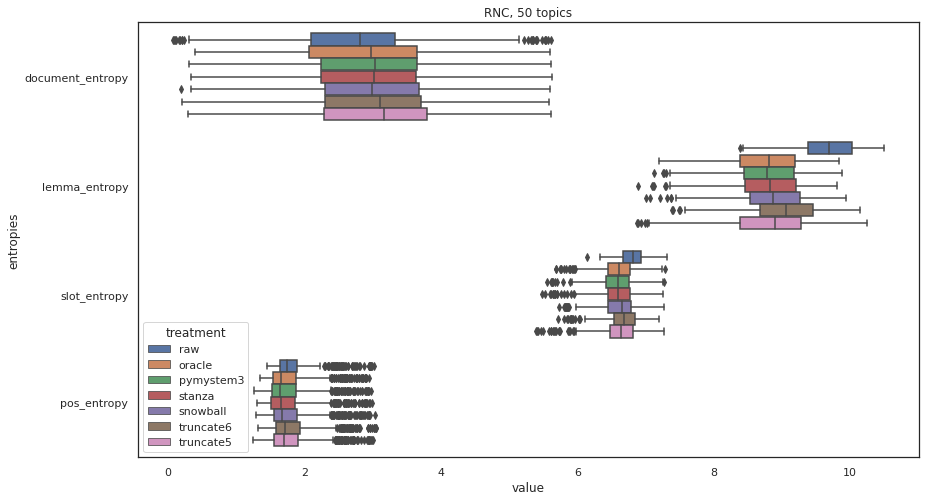

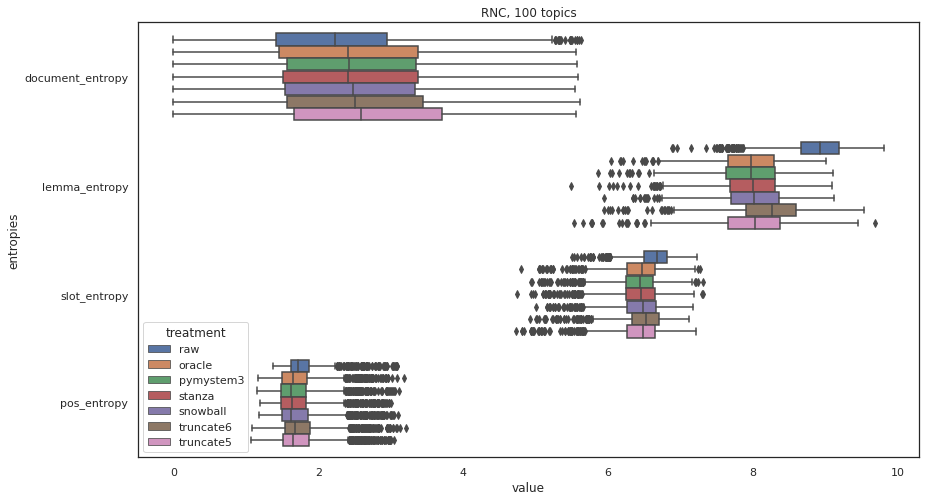

In [9]:
for i, pair in enumerate(num_topics_splits):
    num_topics, df = pair
    entropy_metrics = ['document_entropy', 'lemma_entropy', 'slot_entropy', 'pos_entropy']
    entropy_stats = pd.melt(df, "treatment", var_name="entropies", value_vars=entropy_metrics)
    plt.figure(i)
    fig, axs = plt.subplots(figsize=(14, 8))
    sns.boxplot(x="value", y="entropies", hue="treatment", data = entropy_stats, hue_order=hue_order).set_title(f"{corpus_name.upper()}, {num_topics} topics")

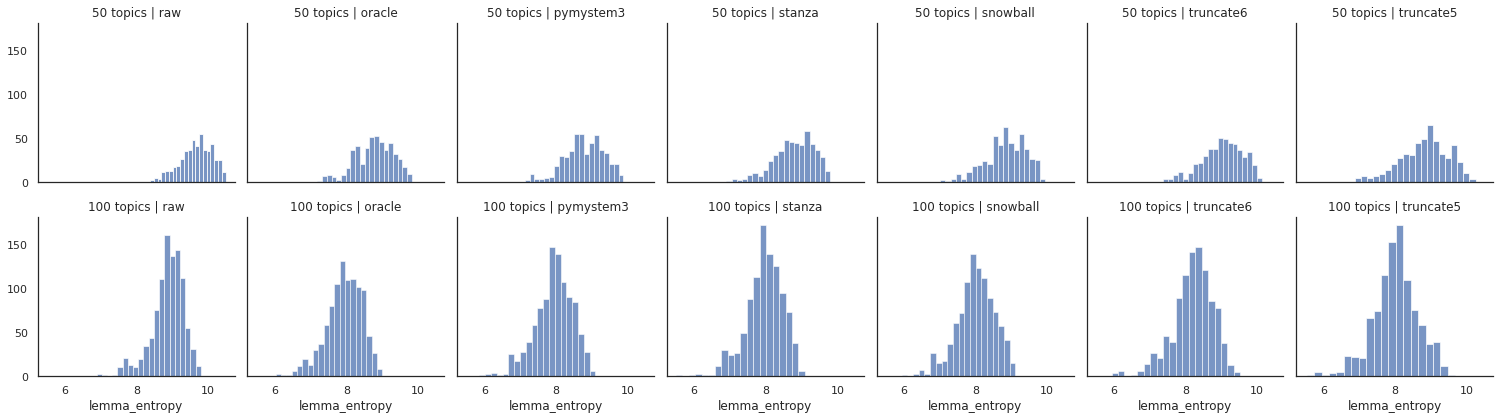

In [10]:
g = sns.FacetGrid(full_frame, col="treatment", row="num_topics", col_order=hue_order)
g.map(sns.histplot, "lemma_entropy", bins=20)
g.set_titles(col_template="{col_name}", row_template= "{row_name} topics")

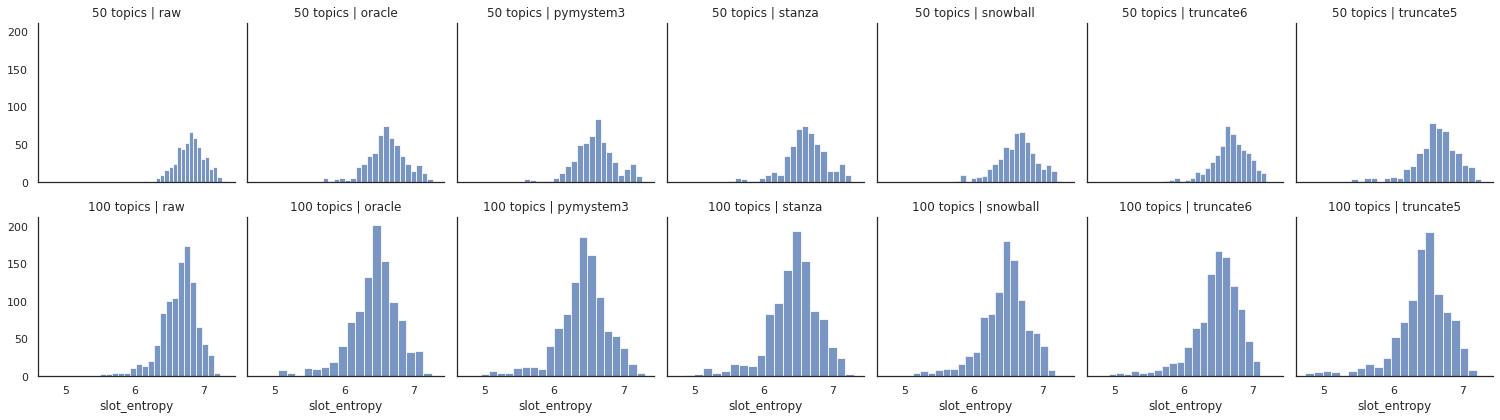

In [11]:
g = sns.FacetGrid(full_frame, col="treatment", row="num_topics", col_order=hue_order)
g.map(sns.histplot, "slot_entropy", bins=20)
g.set_titles(col_template="{col_name}", row_template= "{row_name} topics")

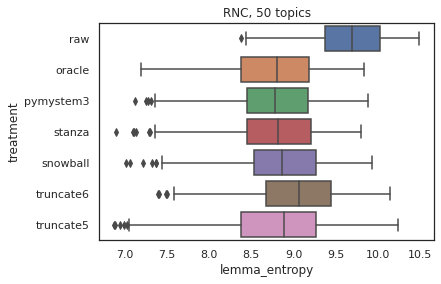

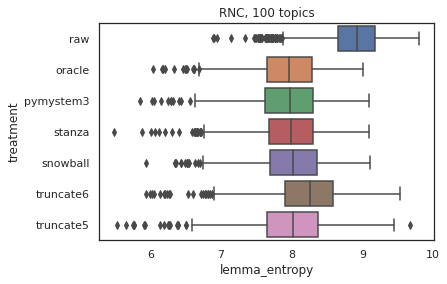

In [12]:
for i, pair in enumerate(num_topics_splits):
    num_topics, df = pair
    plt.figure(i)
    sns.boxplot(x='lemma_entropy', y='treatment', data=df, order=hue_order).set_title(f"{corpus_name.upper()}, {num_topics} topics")

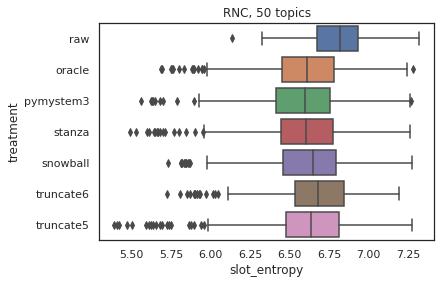

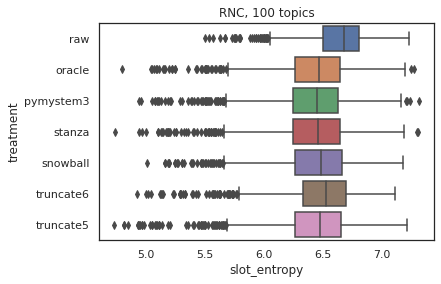

In [13]:
for i, pair in enumerate(num_topics_splits):
    num_topics, df = pair
    plt.figure(i)
    sns.boxplot(x='slot_entropy', y='treatment', data=df, order=hue_order).set_title(f"{corpus_name.upper()}, {num_topics} topics")

<Figure size 432x288 with 0 Axes>

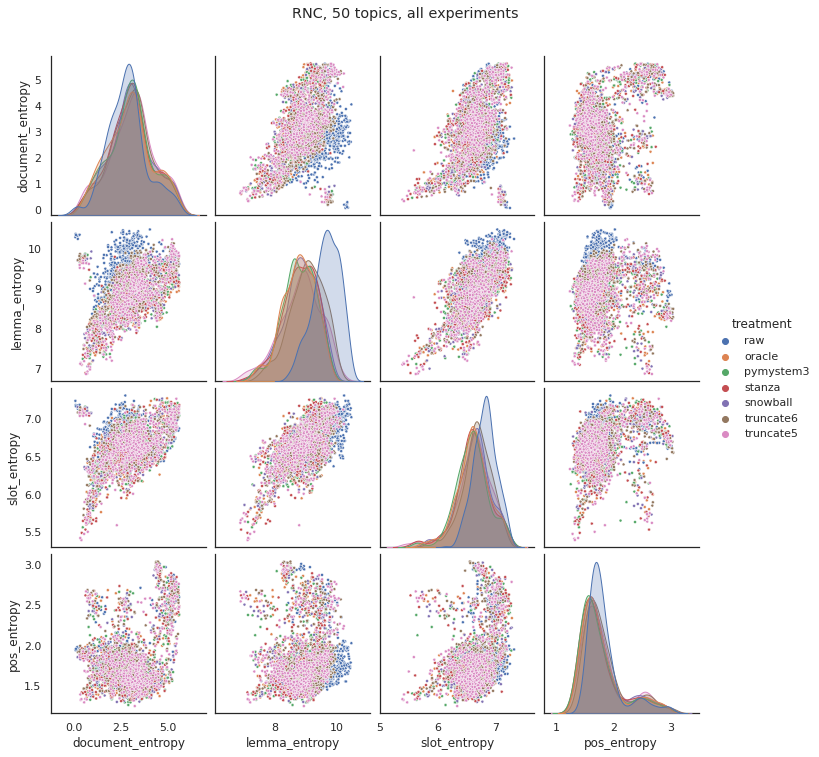

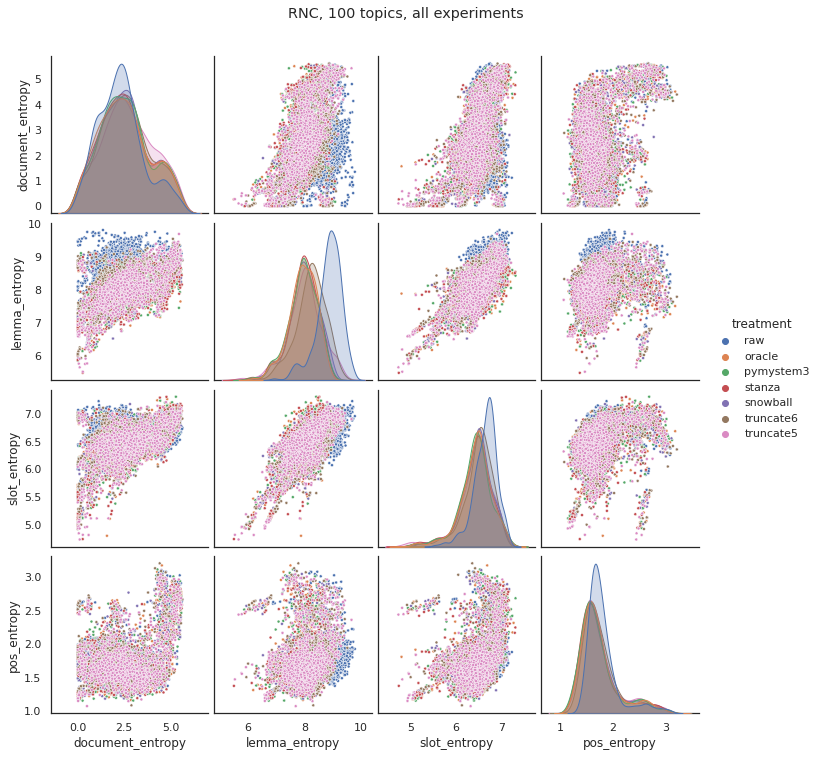

In [14]:
for i, pair in enumerate(num_topics_splits):
    num_topics, df = pair
    plt.figure(i)
    g = sns.pairplot(df, hue="treatment", vars=entropy_metrics, markers='.', hue_order=hue_order)
    g.fig.suptitle(f"{corpus_name.upper()}, {num_topics} topics, all experiments", y = 1.05)

<Figure size 432x288 with 0 Axes>

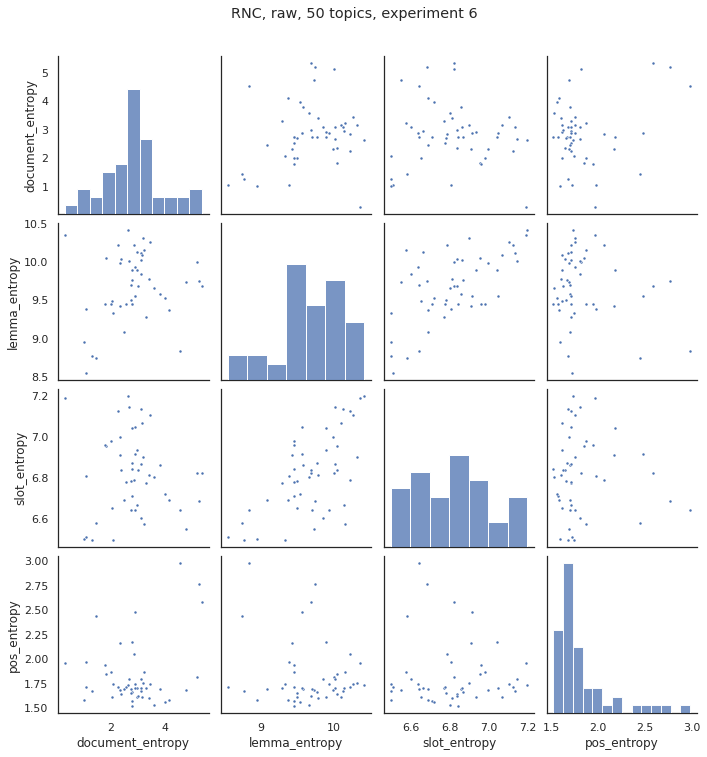

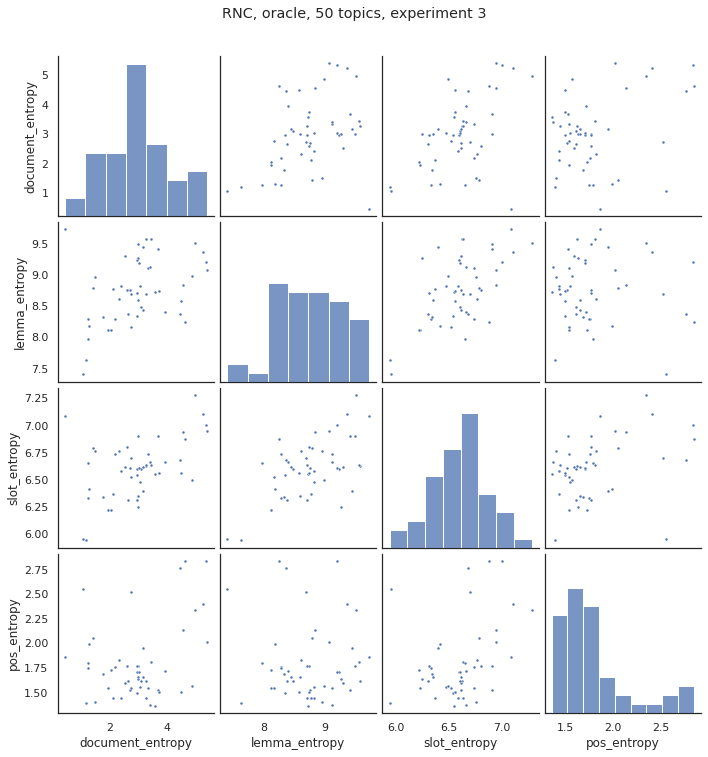

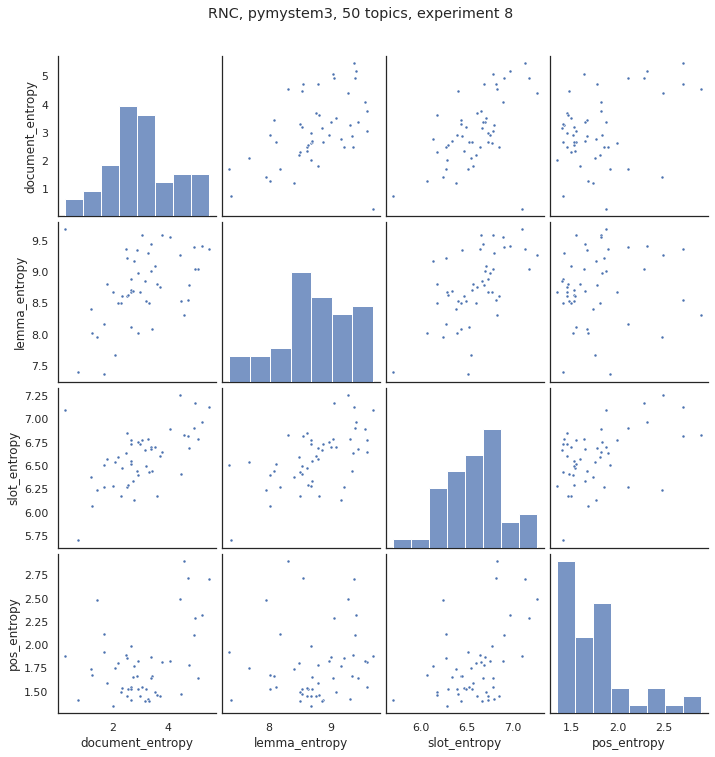

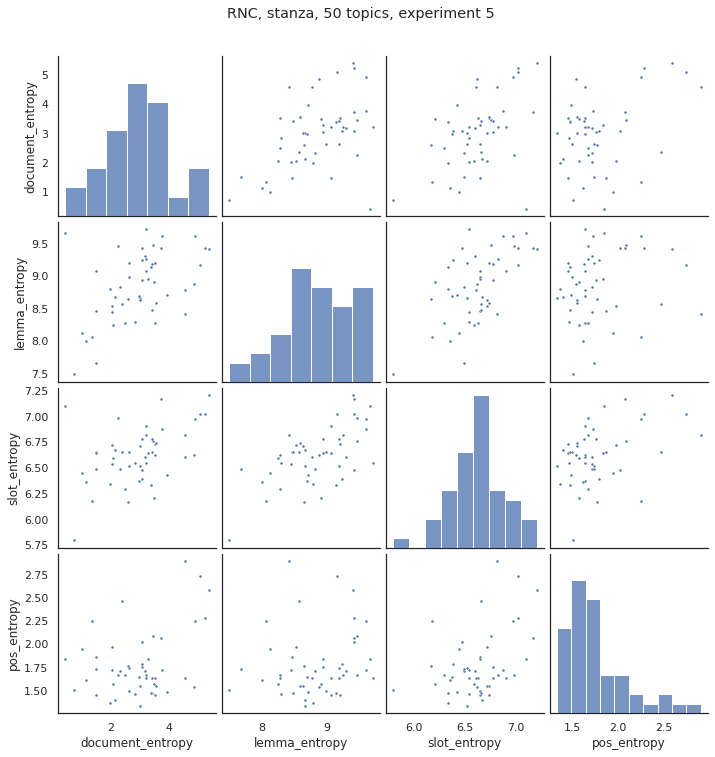

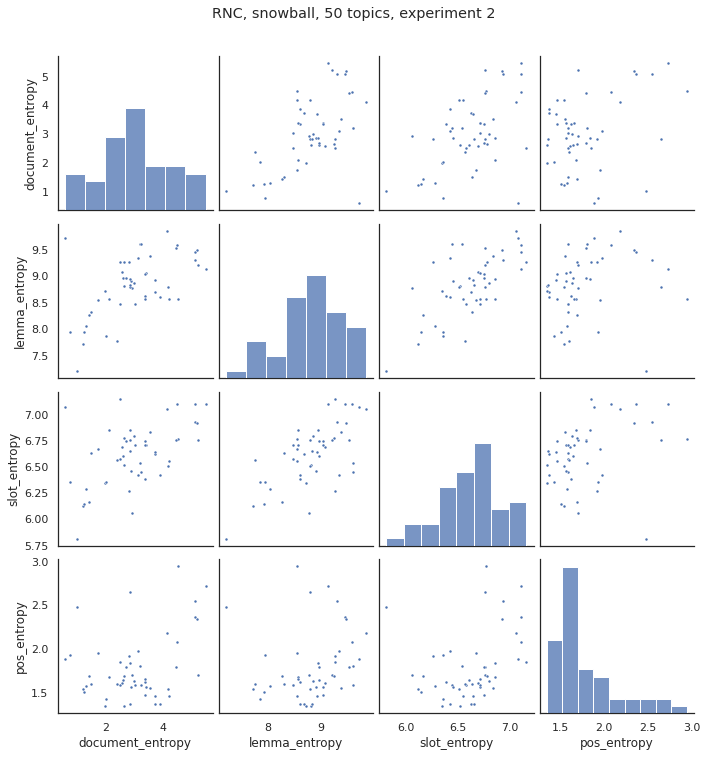

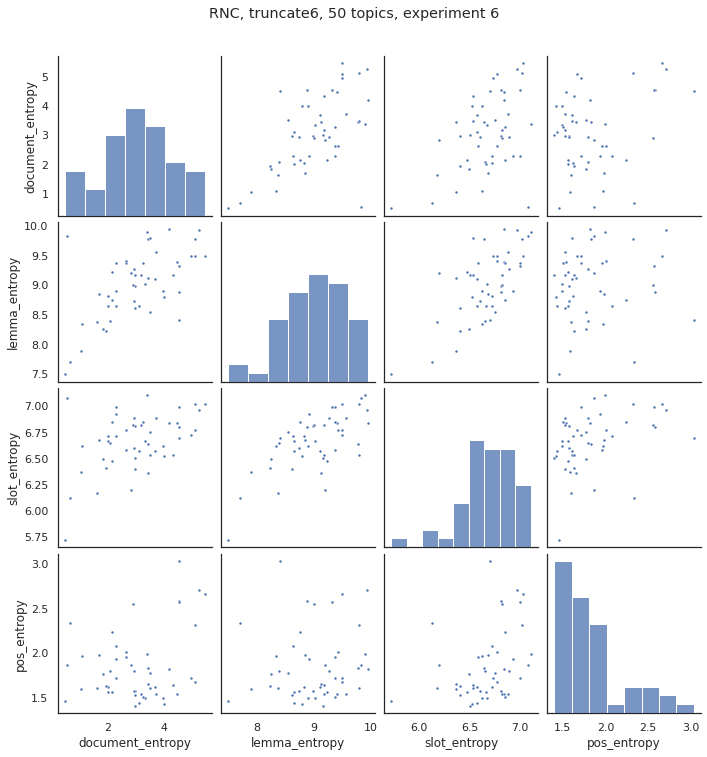

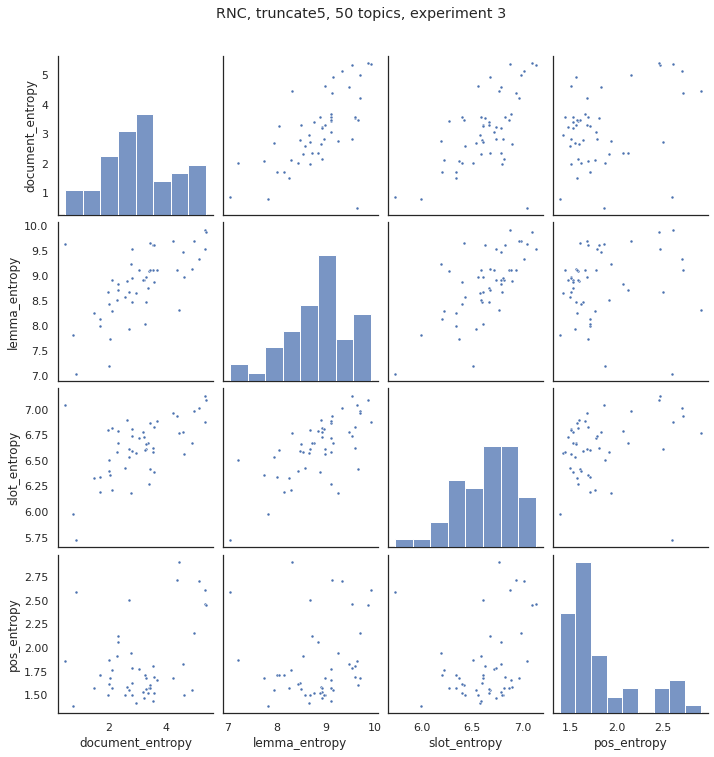

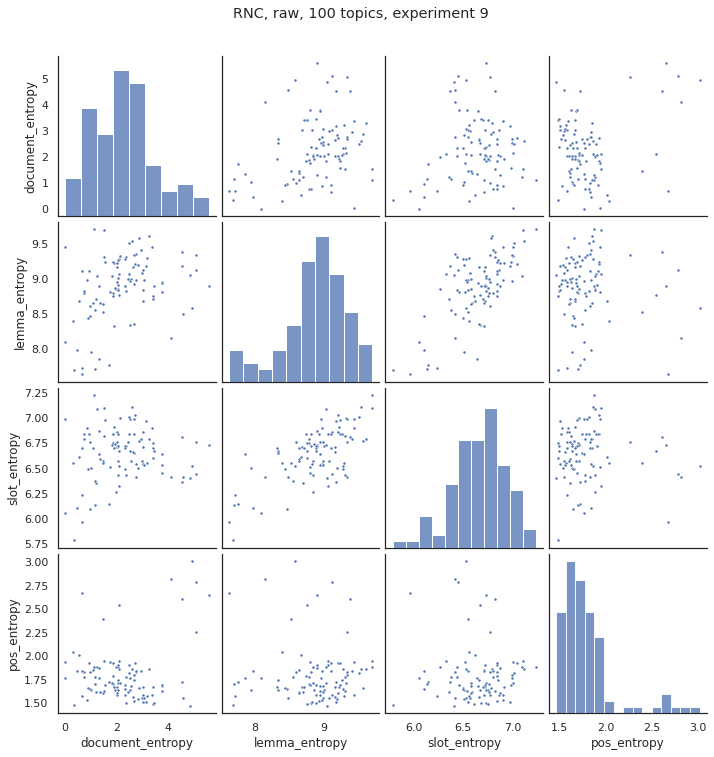

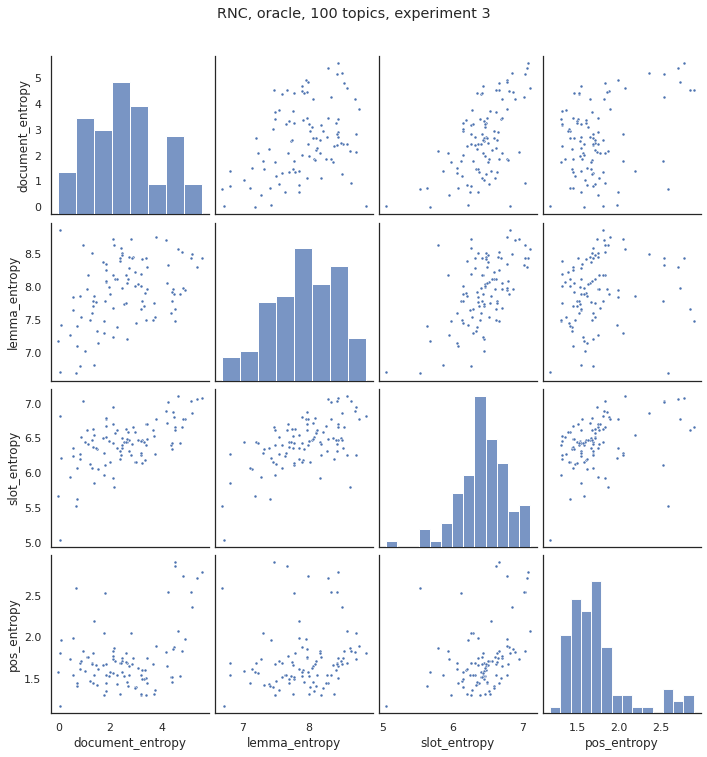

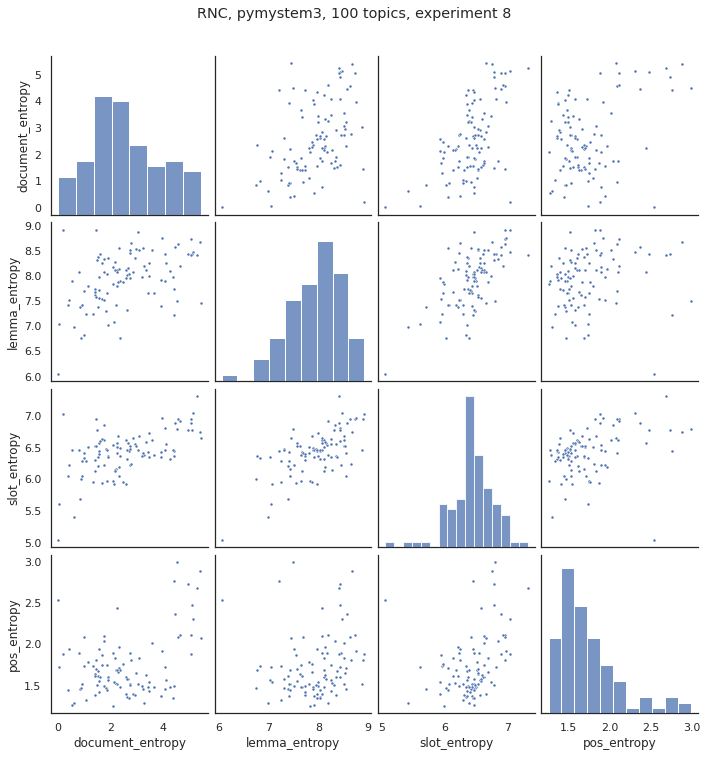

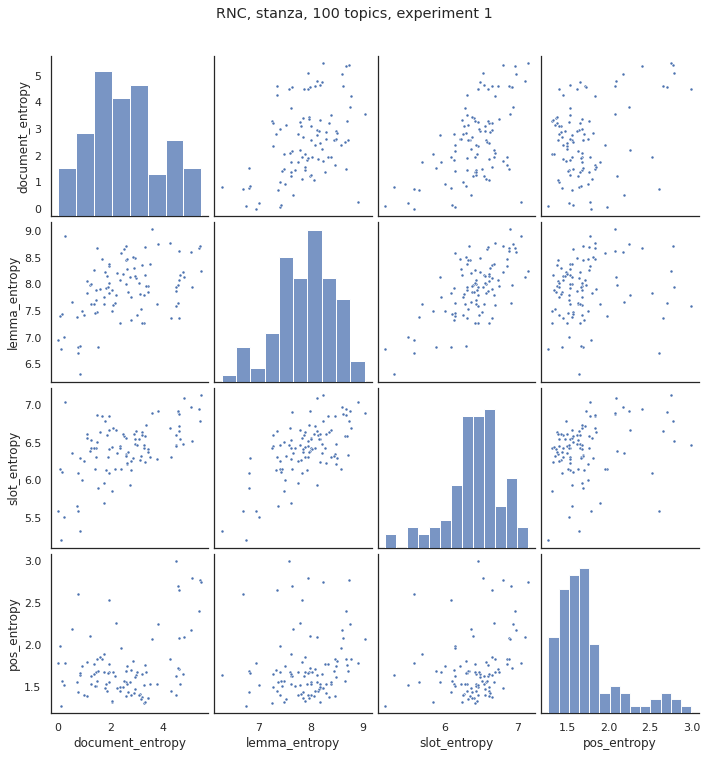

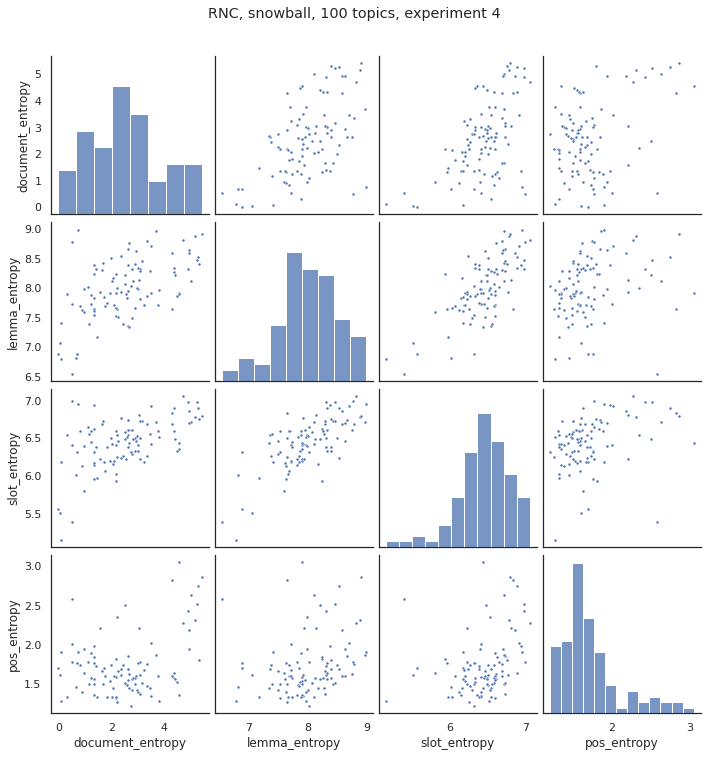

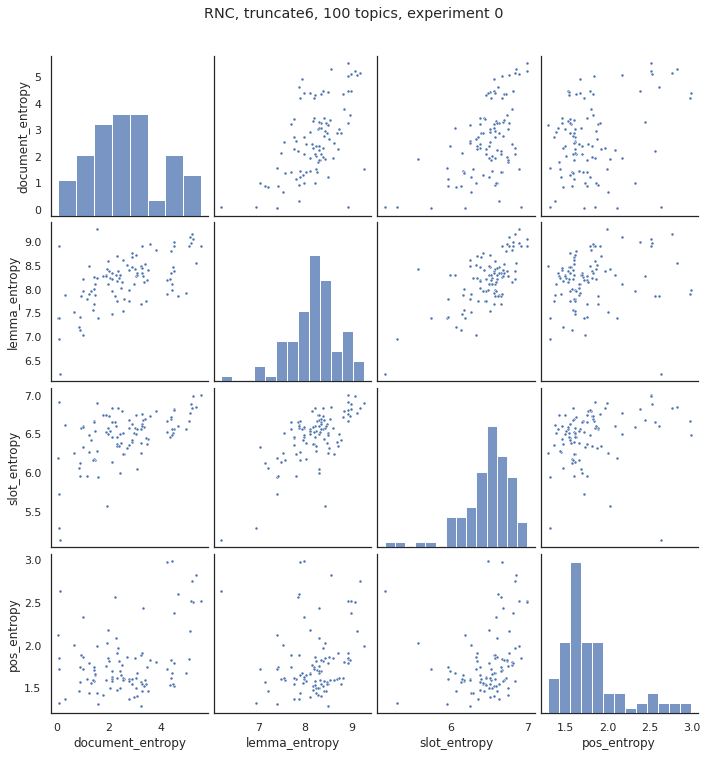

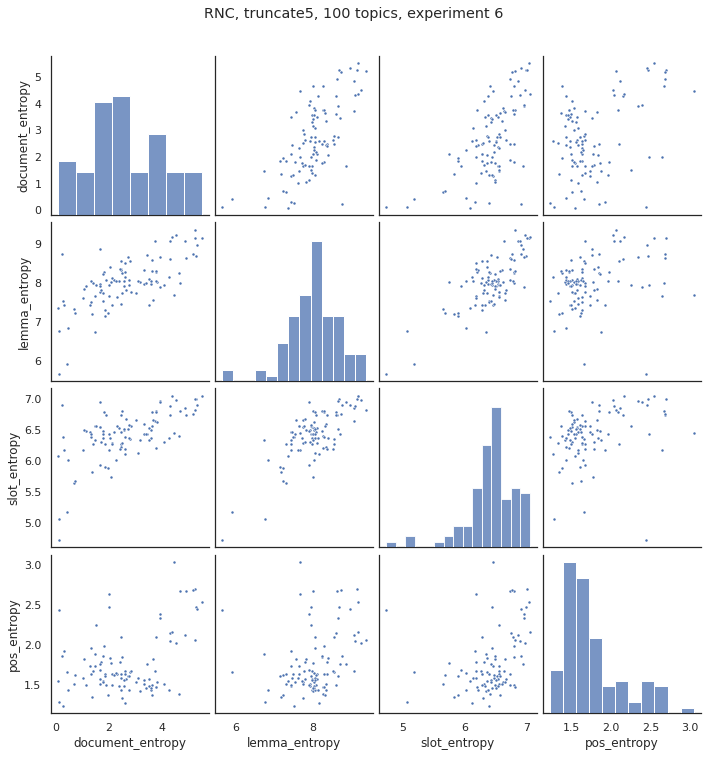

In [15]:
    # The same pair plots for a single experiment in each stemmer type
    counter = 0
    for i, pair in enumerate(num_topics_splits):
        num_topics, df = pair
        for treatment in hue_order:
            tmp_df = df[df['treatment'] == treatment]
            experiment_id = random.randrange(10)
            tmp_df = tmp_df[tmp_df['experiment_id'] == str(experiment_id)]
            plt.figure(counter)
            g = sns.pairplot(tmp_df, vars=entropy_metrics, markers='.')
            g.fig.suptitle(f"{corpus_name.upper()}, {treatment}, {num_topics} topics, experiment {experiment_id}", y = 1.05)
            counter+=1

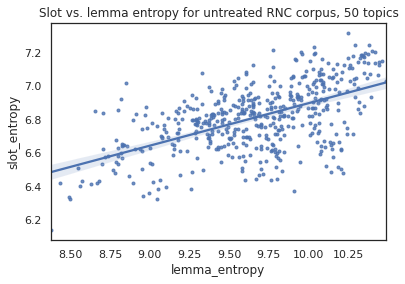

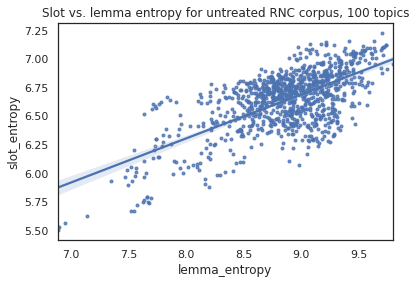

In [16]:
for i, pair in enumerate(num_topics_splits):
    num_topics, df = pair
    plt.figure(i)
    raw_df = df[df['treatment'] == 'raw'][['experiment_id', 'topic_id', 'num_topics', 'lemma_entropy', 'slot_entropy', 'top_20_term_set', 'top_20_lemma_set', 'lemmas_in_top_20_terms', 'top_lemmas_minus_top_term_lemmas', 'num_lemmas_in_top_20_terms', 'num_top_lemmas_excluded_by_top_terms']]
    sns.regplot(data=raw_df, x="lemma_entropy", y="slot_entropy", marker=".").set_title(f"Slot vs. lemma entropy for untreated {corpus_name.upper()} corpus, {num_topics} topics")

Slope: 0.2533863583135643 Intercept: 4.362373109478698 r: 0.5656832199357604 r^2: 0.3199975053168899
Slot entropy stddev: 0.19863834742000885
Lemma entropy stdev: 0.4434586799349949
Slope: 0.38533759624463493 Intercept: 3.221861539455605 r: 0.6669977966592838 r^2: 0.4448860607483393
Slot entropy stddev: 0.26348251217603913
Lemma entropy stdev: 0.45607347113905683


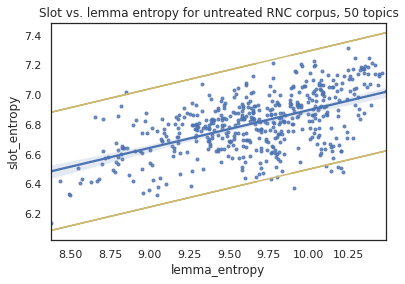

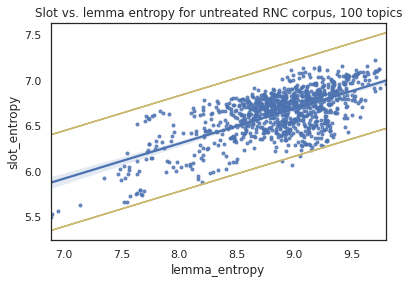

In [17]:
for i, pair in enumerate(num_topics_splits):
    num_topics, df = pair
    plt.figure(i)
    raw_df = df[df['treatment'] == 'raw'][['experiment_id', 'topic_id', 'num_topics', 'lemma_entropy', 'slot_entropy', 'top_20_term_set', 'top_20_lemma_set', 'lemmas_in_top_20_terms', 'top_lemmas_minus_top_term_lemmas', 'num_lemmas_in_top_20_terms', 'num_top_lemmas_excluded_by_top_terms']]
    x_data = raw_df["lemma_entropy"]
    y_data = raw_df["slot_entropy"]
    # Following https://stats.libretexts.org/Bookshelves/Introductory_Statistics/Book%3A_Introductory_Statistics_(OpenStax)/12%3A_Linear_Regression_and_Correlation/12.07%3A_Outliers
    res = stats.linregress(x_data, y_data)
    print("Slope:", res.slope, "Intercept:", res.intercept, "r:", res.rvalue, "r^2:", res.rvalue**2)
    y_stdev = np.std(y_data)
    print("Slot entropy stddev:", y_stdev)
    x_stdev = np.std(x_data)
    print("Lemma entropy stdev:", x_stdev)
    plt.plot(x_data, res.intercept + res.slope*x_data + 2*y_stdev, 'y')
    plt.plot(x_data, res.intercept + res.slope*x_data - 2*y_stdev, 'y')
    sns.regplot(data=raw_df, x="lemma_entropy", y="slot_entropy", marker=".").set_title(f"Slot vs. lemma entropy for untreated {corpus_name.upper()} corpus, {num_topics} topics")

50 topic experiments, low lemma entropy: 17 topics


,experiment_id,topic_id,num_topics,lemma_entropy,slot_entropy,top_20_term_set,top_20_lemma_set,lemmas_in_top_20_terms,top_lemmas_minus_top_term_lemmas,num_lemmas_in_top_20_terms,num_top_lemmas_excluded_by_top_terms
2652,2,2,50,8.378958,6.137453,петровна надежда мать прохожий алексей руки данильцев иннокентий наталья терехова анатолий adobe демидова солоницын алла звонит маргарита лиза смоктуновский игнат,открывать рука петровна надежда муж мать алексей данильцев иннокентий наталья терехова анатолий adobe демидова алла маргарита лиза смоктуновский звонить игнат,рука петровна надежда мать прохожий алексей данильцев иннокентий наталья терехова анатолий adobe демидова солоницын алла маргарита лиза смоктуновский звонить игнат,муж открывать,20,2
1522,8,22,50,8.433884,6.423197,замечательной кп угу париже смеётся русском камий нрзбр э капри знаете значит ээ т мм знал ам наверно смех аа,кп угу фотография русский замечательный неразборчиво знать любовь а камий э капри значит язык смеяться мм ам наверно смех достать,кп угу русский замечательный неразборчиво знать а камий э капри париж значить значит ээ т смеяться мм ам наверно э-э смех,любовь язык фотография достать,21,4
2687,2,37,50,8.490771,6.334878,угу всё-таки ам кп музыка играть джаз смеётся вопрос значит мм аа ээ смех знаете э гребенщиков музыки капри наверно,угу интересный замечательный ам кп музыка джаз вопрос значит мм неразборчиво русский а смех смеяться знать э гребенщиков альбом язык,угу всё-таки ам кп музыка играть джаз вопрос значит мм а ээ смех смеяться знать э значить э-э гребенщиков капри наверно,неразборчиво интересный замечательный альбом русский язык,21,6
2253,0,3,50,8.497230,6.326546,надежда петровна руки смоктуновский л маргарита алексей наталья игнат демидова лиза ой данильцев терехова c н мать анатолий иннокентий алла,надежда петровна смоктуновский л маргарита алексей рука наталья игнат демидова лиза данильцев терехова н звонить мать анатолий иннокентий алла с,надежда петровна смоктуновский л маргарита алексей рука наталья игнат литр демидова лиза ой данильцев терехова н мать анатолий иннокентий алла с,звонить,21,1
2982,6,32,50,8.546013,6.508993,женщина мужчин алексей м игнат маргарита алла женщины наталья иннокентий женщин лиза лахова мужчины е ганапольский терехова мать данилова смоктуновский,женщина екатерина алексей м игнат маргарита алла демидова наталья иннокентий лиза лахова е ганапольский мужчина терехова мать данилова смоктуновский петровна,женщина алексей м игнат маргарита алла наталья иннокентий лиза лахова москва е ганапольский метр мужчина терехова мать данилова смоктуновский,екатерина петровна демидова,19,3
1523,8,23,50,8.559374,6.404138,матери алексей данильцев алла прохожий иннокентий звонит анатолий смоктуновский демидова маргарита маша игнат наталья надежда руки петровна мать лиза терехова,твой алексей открывать данильцев алла иннокентий анатолий смоктуновский рука демидова маргарита маша игнат наталья надежда петровна мать звонить лиза терехова,алексей данильцев алла прохожий иннокентий анатолий смоктуновский рука демидова маргарита маша игнат наталья надежда петровна мать звонить лиза терехова,твой открывать,19,2
2930,9,30,50,8.574545,6.434052,катя зале спасибо пожалуйста номер денис аа ээ сёмин угу ам смех следующий вопрос шагинян кп удальцов аплодисменты значит артём,катя пожалуйста зал юрий номер денис семин знать локомотив угу ам смех вопрос шагинян кп удальцов э аплодисменты значит артем,катя спасибо пожалуйста а зал номер денис семин значить угу ам смех следующий вопрос шагинян кп удальцов э аплодисменты значит артем,локомотив юрий знать,21,3
1780,4,30,50,8.628249,6.411822,прохожий демидова иннокентий маргарита маша матери звонит данильцев наталья анатолий мать руки игнат терехова алла смоктуновский петровна алексей лиза надежда,прохожий демидова голос иннокентий маргарита маша данильцев наталья звонить анатолий мать игнат терехова рука алла смоктуновский петровна алексей лиза надежда,прохожий демидова иннокентий маргарита маша данильцев 

50 topic_experiments, low slot entropy: 12 topics


,experiment_id,topic_id,num_topics,lemma_entropy,slot_entropy,top_20_term_set,top_20_lemma_set,lemmas_in_top_20_terms,top_lemmas_minus_top_term_lemmas,num_lemmas_in_top_20_terms,num_top_lemmas_excluded_by_top_terms
2652,2,2,50,8.378958,6.137453,петровна надежда мать прохожий алексей руки данильцев иннокентий наталья терехова анатолий adobe демидова солоницын алла звонит маргарита лиза смоктуновский игнат,открывать рука петровна надежда муж мать алексей данильцев иннокентий наталья терехова анатолий adobe демидова алла маргарита лиза смоктуновский звонить игнат,рука петровна надежда мать прохожий алексей данильцев иннокентий наталья терехова анатолий adobe демидова солоницын алла маргарита лиза смоктуновский звонить игнат,муж открывать,20,2
2253,0,3,50,8.497230,6.326546,надежда петровна руки смоктуновский л маргарита алексей наталья игнат демидова лиза ой данильцев терехова c н мать анатолий иннокентий алла,надежда петровна смоктуновский л маргарита алексей рука наталья игнат демидова лиза данильцев терехова н звонить мать анатолий иннокентий алла с,надежда петровна смоктуновский л маргарита алексей рука наталья игнат литр демидова лиза ой данильцев терехова н мать анатолий иннокентий алла с,звонить,21,1
2905,9,5,50,9.043434,6.327197,потом года муж помню здесь информант респондент годы ходила интервьюер комната жили говорю войны ходили квартира квартире году жила ой,потом любить год приехать муж завод говорить купить здесь информант война респондент интервьюер комната жить знать ходить квартира работать помнить,комната жить потом говорить здесь ходить жила ой год квартира информант война помнить респондент муж интервьюер,завод знать купить любить работать приехать,16,6
2687,2,37,50,8.490771,6.334878,угу всё-таки ам кп музыка играть джаз смеётся вопрос значит мм аа ээ смех знаете э гребенщиков музыки капри наверно,угу интересный замечательный ам кп музыка джаз вопрос значит мм неразборчиво русский а смех смеяться знать э гребенщиков альбом язык,угу всё-таки ам кп музыка играть джаз вопрос значит мм а ээ смех смеяться знать э значить э-э гребенщиков капри наверно,неразборчиво интересный замечательный альбом русский язык,21,6
2316,3,16,50,8.958111,6.341300,здесь комната знаю года дом войны ой интервьюер респондент кафе квартире ходили говорю квартира потом муж помню году жила жили,говорить работать здесь ходить комната знать год дом ой интервьюер приехать респондент помнить квартира потом муж купить война жить ленинград,потом ой кафе говорить муж здесь интервьюер ходить комната знать помнить год дом жила квартира война жить респондент,приехать купить ленинград работать,18,4
2684,2,34,50,8.996247,6.360974,дом года сюда информант ой потом квартира муж ходили куда респондент жили комната году помню мама тогда жила интервьюер квартире,дом магазин сюда информант ой потом завод квартира муж ленинград жить респондент комната год работать ходить приехать помнить интервьюер язык,дом сюда информант ой потом квартира муж жить куда респондент комната год ходить мама дом|дом тогда жила помнить интервьюер,магазин работать приехать ленинград завод язык,19,6
1937,7,37,50,9.908364,6.373226,распространения ru клиентов компании компания проекта рынке сми рынка сети информации издания сбыта xgi adobe магазинов рекламы изданий интернет пользователей,ru издатель вирус компания пользователь издание магазин информация покупатель сайт клиент данные реклама распространение рекламный интернет продажа рынок товар сеть,сеть|сеть сбыт реклама информация интернет ru проект рынок распространение издание клиент компания пользователь xgi adobe сеть сми магазин,данные продажа издатель товар рекламный покупатель вирус сайт,18,8
1790,4,40,50,9.050815,6.382798,помню респондент квартира ой квартире приехала жила году жили потом здесь муж заводе говорю года тогда ходили интервьюер камий знаю,респондент купить говорить жить квартира ой работать ходить приехать потом муж здесь дом интервьюер комната помнить ленинград завод знать год,ходить респондент камий говорить жить к

100 topic experiments, low lemma entropy: 57 topics


,experiment_id,topic_id,num_topics,lemma_entropy,slot_entropy,top_20_term_set,top_20_lemma_set,lemmas_in_top_20_terms,top_lemmas_minus_top_term_lemmas,num_lemmas_in_top_20_terms,num_top_lemmas_excluded_by_top_terms
1617,0,67,100,6.885319,5.499099,ам угу смех знаете знал лет наверно париже русском аплодисменты кадры кп россию мм замечательной ээ значит насколько т аа,ам угу смех э приехать наверно россия замечательный кадр кп бунин год мм знать русский а значит язык т дед,ам угу смех э наверно россия замечательный аплодисменты значить кадр париж кп э-э год мм знать русский а ээ значит насколько т,дед бунин приехать язык,22,4
2736,4,36,100,6.894231,5.528977,языке ам угу кадры попросили знал т ээ смех аплодисменты мм наверно значит знаете кп замечательной тогда россию насколько аа,ам угу т бунин смех американец значить мм наверно попросить э значит а знать кп тогда язык замечательный русский россия,ам угу т ээ смех аплодисменты значить мм наверно попросить э значит а знать кп тогда язык замечательный кадр насколько россия,американец бунин русский,21,3
2373,1,23,100,6.944798,5.565627,россию кадры замечательной кп ам лет любви наверно смех аплодисменты знаете т русском насколько аа угу ээ мм значит знал,э язык кп ам наверно смех а россия русский т насколько кадр год замечательный угу значить мм значит бунин знать,э кп ам наверно смех а россия русский аплодисменты т насколько кадр любовь год замечательный угу значить ээ мм значит знать э-э,язык бунин,22,2
2462,3,12,100,7.138329,5.625688,значит русском дед аа наверно кп алексей насколько ам аплодисменты кадры мм угу смех ээ знал россию замечательной знаете т,значит замечательный дед россия знать наверно кп а приехать язык насколько ам мм американец русский угу смех э кадр т,значит замечательный дед значить россия знать наверно кп а алексей насколько ам аплодисменты мм русский угу смех ээ э кадр т,приехать американец язык,21,3
1979,2,29,100,7.346132,5.930038,федеральной форме юридическими федерального n осуществляющими статистики сведения лицами организациями год органами россии срочная подразделениями государственной обособленными цены тариф средств,обособленный имущество орган n юридический организация федеральный год форма статистика государственный тариф осуществлять сведение цена средство приватизация постановление лицо подразделение,обособленный орган n юридический срочный организация федеральный год форма статистика россия государственный тариф осуществлять сведение цена средство лицо подразделение,имущество приватизация постановление,19,3
1684,6,34,100,7.466010,5.964752,знаете насколько азербайджана тогда язык т русском ээ информант русского угу наверно аа значит кп азербайджане языке русский азербайджан ам,насколько россия тогда язык знать т а информант угу замечательный наверно славянский значит кп по-фински русский э азербайджан ам азербайджанский,русское э-э насколько тогда язык знать т а значить информант угу наверно значит кп так русский э азербайджан ам,по-фински россия замечательный славянский азербайджанский,19,5
1687,6,37,100,7.485735,6.027814,подразделениями осуществляющими n форме россии уголь федеральной средств тариф юридическими государственной организациями федерального обособленными постановлением цены органами лицами статистики сведения,подразделение федеральный россия n постановление организация осуществлять государственный уголь сведение юридический орган тариф форма обособленный статистика цена лицо имущество служба,подразделение федеральный россия n постановление организация осуществлять государственный уголь сведение юридический орган тариф форма обособленный статистика цена средство лицо,служба имущество,19,2
1968,2,18,100,7.496536,5.898897,нрзбр смех т розы мм россию наверно знаете значит ээ кп угу аа кадры э капри ам париже смеётся замечательной,смех т макароны мм наверно русский а смеяться значит знать кп достать угу замечательный неразборчиво россия э капри ам фотография,смех т значить мм наверно кадр а смеяться париж значит знать ээ кп угу замечате

100 topic_experiments, low slot entropy: 48 topics


,experiment_id,topic_id,num_topics,lemma_entropy,slot_entropy,top_20_term_set,top_20_lemma_set,lemmas_in_top_20_terms,top_lemmas_minus_top_term_lemmas,num_lemmas_in_top_20_terms,num_top_lemmas_excluded_by_top_terms
1617,0,67,100,6.885319,5.499099,ам угу смех знаете знал лет наверно париже русском аплодисменты кадры кп россию мм замечательной ээ значит насколько т аа,ам угу смех э приехать наверно россия замечательный кадр кп бунин год мм знать русский а значит язык т дед,ам угу смех э наверно россия замечательный аплодисменты значить кадр париж кп э-э год мм знать русский а ээ значит насколько т,дед бунин приехать язык,22,4
2736,4,36,100,6.894231,5.528977,языке ам угу кадры попросили знал т ээ смех аплодисменты мм наверно значит знаете кп замечательной тогда россию насколько аа,ам угу т бунин смех американец значить мм наверно попросить э значит а знать кп тогда язык замечательный русский россия,ам угу т ээ смех аплодисменты значить мм наверно попросить э значит а знать кп тогда язык замечательный кадр насколько россия,американец бунин русский,21,3
2373,1,23,100,6.944798,5.565627,россию кадры замечательной кп ам лет любви наверно смех аплодисменты знаете т русском насколько аа угу ээ мм значит знал,э язык кп ам наверно смех а россия русский т насколько кадр год замечательный угу значить мм значит бунин знать,э кп ам наверно смех а россия русский аплодисменты т насколько кадр любовь год замечательный угу значить ээ мм значит знать э-э,язык бунин,22,2
2462,3,12,100,7.138329,5.625688,значит русском дед аа наверно кп алексей насколько ам аплодисменты кадры мм угу смех ээ знал россию замечательной знаете т,значит замечательный дед россия знать наверно кп а приехать язык насколько ам мм американец русский угу смех э кадр т,значит замечательный дед значить россия знать наверно кп а алексей насколько ам аплодисменты мм русский угу смех ээ э кадр т,приехать американец язык,21,3
1553,0,3,100,7.523957,5.665275,смоктуновский лиза алексей солоницын военрук мать игнат петровна алла типографии руки надежда терехова демидова анатолий маргарита данильцев наталья прохожий иннокентий,смоктуновский лиза алексей солоницын мать игнат алеша петровна алла типография надежда терехова демидова рука анатолий маргарита данильцев наталья прохожий иннокентий,смоктуновский лиза алексей солоницын военрук мать игнат петровна алла типография надежда терехова демидова рука анатолий маргарита данильцев наталья прохожий иннокентий,алеша,20,1
2381,1,31,100,7.543193,5.665406,игнат данильцев иннокентий надежда наталья смоктуновский руки анатолий алла солоницын лиза петровна алексей терехова мать маргарита демидова типографии прохожий военрук,игнат данильцев иннокентий надежда наталья смоктуновский звонить анатолий алеша алла солоницын лиза петровна алексей терехова мать маргарита демидова прохожий рука,игнат типография данильцев иннокентий надежда наталья смоктуновский анатолий алла солоницын лиза петровна алексей терехова мать маргарита демидова прохожий рука военрук,звонить алеша,20,2
2247,5,97,100,7.575952,5.725436,солоницын терехова данильцев типографии демидова иннокентий лиза петровна наталья руки надежда анатолий игнат маргарита военрук алексей мать алла прохожий смоктуновский,солоницын терехова данильцев демидова алеша иннокентий лиза петровна наталья рука надежда типография анатолий игнат маргарита военрук алексей мать алла смоктуновский,солоницын терехова данильцев демидова иннокентий лиза петровна наталья рука надежда типография анатолий игнат маргарита военрук алексей мать алла прохожий смоктуновский,алеша,20,1
2581,8,31,100,7.672304,5.742452,петровна анатолий маргарита игнат смоктуновский наталья юрий демидова военрук мать надежда иннокентий алла типографии алексей прохожий солоницын терехова лиза данильцев,петровна анатолий маргарита игнат смоктуновский наталья демидова типография военрук мать надежда иннокентий алла алексей прохожий солоницын алеша терехова лиза данильцев,петровна анатолий маргарита игнат смоктуновский наталья юрий демидова типография

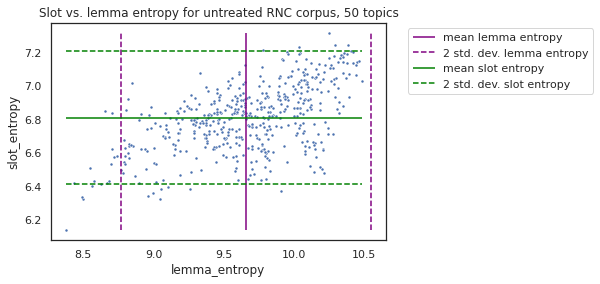

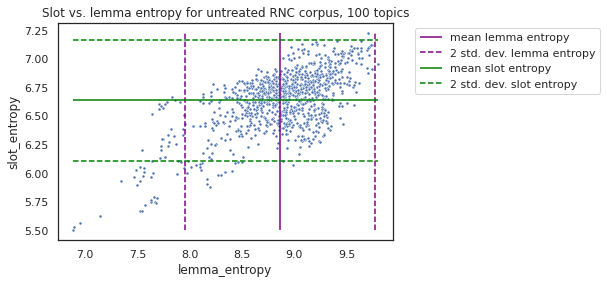

In [18]:
for i, pair in enumerate(num_topics_splits):
    num_topics, df = pair
    plt.figure(i)
    raw_df = df[df['treatment'] == 'raw'][['experiment_id', 'topic_id', 'num_topics', 'lemma_entropy', 'slot_entropy', 'top_20_term_set', 'top_20_lemma_set', 'lemmas_in_top_20_terms', 'top_lemmas_minus_top_term_lemmas', 'num_lemmas_in_top_20_terms', 'num_top_lemmas_excluded_by_top_terms']]
    x_data = raw_df["lemma_entropy"]
    x_mean = x_data.mean()
    x_stdev = x_data.std()
    xmax = x_data.max()
    xmin = x_data.min()
    lemma_upper = x_mean + 2*x_stdev
    lemma_lower = x_mean - 2*x_stdev
    y_data = raw_df["slot_entropy"]
    y_mean = y_data.mean()
    y_stdev = y_data.std()
    ymin = y_data.min()
    ymax = y_data.max()
    
    slot_upper = y_mean + 2*y_stdev
    slot_lower = y_mean - 2*y_stdev

    low_lemma_entropy = raw_df[raw_df["lemma_entropy"] <= lemma_lower].sort_values(["lemma_entropy", "slot_entropy"])
    low_lemma_entropy.head()
    print(num_topics, "topic experiments, low lemma entropy:", len(low_lemma_entropy), "topics")
    display(low_lemma_entropy)

    low_slot_entropy = raw_df[raw_df["slot_entropy"] <= slot_lower ].sort_values(["slot_entropy", "lemma_entropy"])
    print(num_topics, "topic_experiments, low slot entropy:", len(low_slot_entropy), "topics")
    display(low_slot_entropy)
    
    plt.vlines(x_mean, ymin, ymax, colors='purple', label="mean lemma entropy")
    plt.vlines(x_mean -2*x_stdev, ymin, ymax, colors='purple', linestyles='--', label="2 std. dev. lemma entropy")
    plt.vlines(x_mean +2*x_stdev, ymin, ymax, colors='purple', linestyles='--', )
    plt.hlines(y_mean, xmin, xmax, colors='green', label="mean slot entropy")
    plt.hlines(y_mean -2*y_stdev, xmin, xmax, colors='green', linestyles='--', label="2 std. dev. slot entropy")
    plt.hlines(y_mean +2*y_stdev, xmin, xmax, colors='green', linestyles='--', )
    sns.scatterplot(data=raw_df, x="lemma_entropy", y="slot_entropy", marker=".").set_title(f"Slot vs. lemma entropy for untreated {corpus_name.upper()} corpus, {num_topics} topics")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2)

    

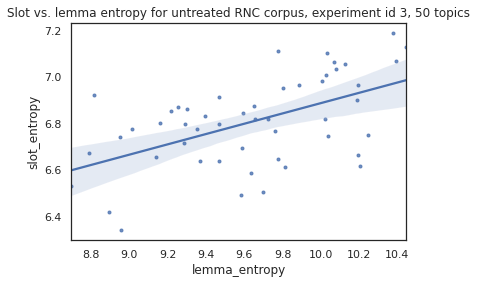

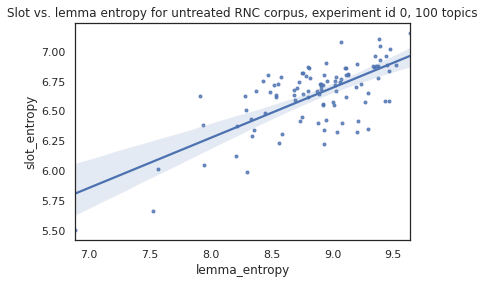

In [19]:
# Compare slot vs lemma entropy for a single experiment
for i, pair in enumerate(num_topics_splits):
    num_topics, df = pair
    plt.figure(i)
    experiment_id = random.randrange(10)
    tmp_df = df[df['experiment_id'] == str(experiment_id)]
    tmp_df = tmp_df[tmp_df['treatment'] == 'raw'][['experiment_id', 'topic_id', 'num_topics', 'lemma_entropy', 'slot_entropy', 'top_20_term_set', 'top_20_lemma_set', 'lemmas_in_top_20_terms', 'top_lemmas_minus_top_term_lemmas', 'num_lemmas_in_top_20_terms', 'num_top_lemmas_excluded_by_top_terms']]
    sns.regplot(data=tmp_df, x="lemma_entropy", y="slot_entropy", marker=".").set_title(f"Slot vs. lemma entropy for untreated {corpus_name.upper()} corpus, experiment id {experiment_id}, {num_topics} topics")

Slope: 0.22110046173298298 Intercept: 4.6763752789675 r: 0.5349712883339993 r^2: 0.286194279341739
Slot entropy stddev: 0.18985442933364788
Lemma entropy stdev: 0.45936886725816584
Slope: 0.4057615268621386 Intercept: 3.0290748331163106 r: 0.6907474150847559 r^2: 0.47713199144627205
Slot entropy stddev: 0.26677991195851203
Lemma entropy stdev: 0.45415230962616854


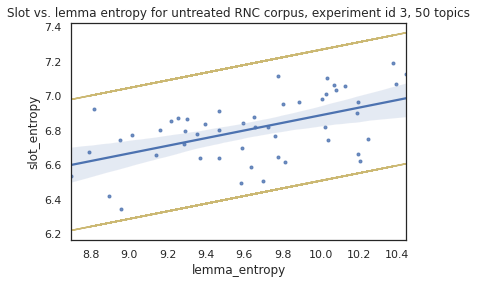

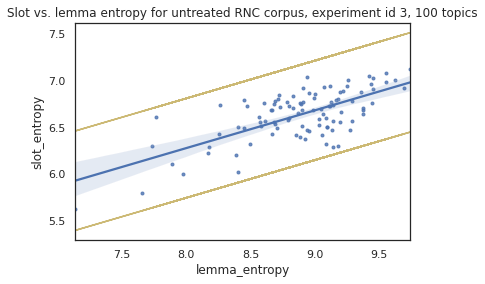

In [20]:
# Compare slot vs lemma entropy for a single experiment
for i, pair in enumerate(num_topics_splits):
    num_topics, df = pair
    plt.figure(i)
    experiment_id = random.randrange(10)
    tmp_df = df[df['experiment_id'] == str(experiment_id)]
    tmp_df = tmp_df[tmp_df['treatment'] == 'raw'][['experiment_id', 'topic_id', 'num_topics', 'lemma_entropy', 'slot_entropy', 'top_20_term_set', 'top_20_lemma_set', 'lemmas_in_top_20_terms', 'top_lemmas_minus_top_term_lemmas', 'num_lemmas_in_top_20_terms', 'num_top_lemmas_excluded_by_top_terms']]
    x_data = tmp_df["lemma_entropy"]
    y_data = tmp_df["slot_entropy"]
    res = stats.linregress(x_data, y_data)
    print("Slope:", res.slope, "Intercept:", res.intercept, "r:", res.rvalue, "r^2:", res.rvalue**2)
    y_stdev = np.std(y_data)
    print("Slot entropy stddev:", y_stdev)
    x_stdev = np.std(x_data)
    print("Lemma entropy stdev:", x_stdev)
    plt.plot(x_data, res.intercept + res.slope*x_data + 2*y_stdev, 'y')
    plt.plot(x_data, res.intercept + res.slope*x_data - 2*y_stdev, 'y')
    sns.regplot(data=tmp_df, x="lemma_entropy", y="slot_entropy", marker=".").set_title(f"Slot vs. lemma entropy for untreated {corpus_name.upper()} corpus, experiment id {experiment_id}, {num_topics} topics")

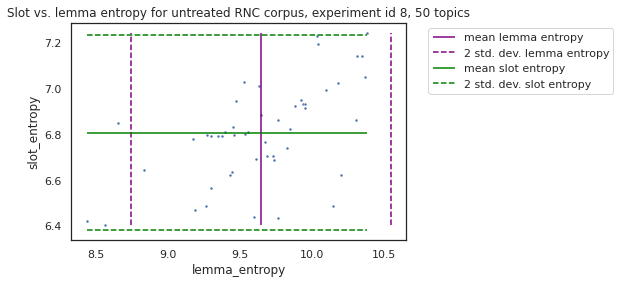

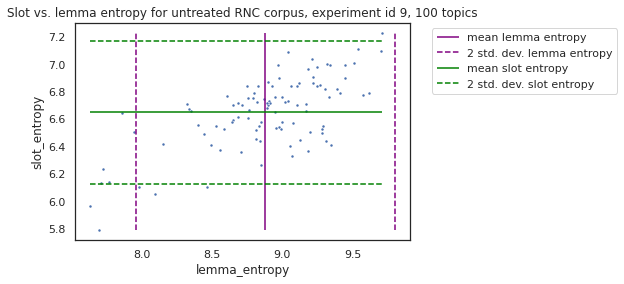

In [21]:
for i, pair in enumerate(num_topics_splits):
    num_topics, df = pair
    plt.figure(i)
    experiment_id = random.randrange(10)
    tmp_df = df[df['experiment_id'] == str(experiment_id)]
    tmp_df = tmp_df[tmp_df['treatment'] == 'raw'][['experiment_id', 'topic_id', 'num_topics', 'lemma_entropy', 'slot_entropy', 'top_20_term_set', 'top_20_lemma_set', 'lemmas_in_top_20_terms', 'top_lemmas_minus_top_term_lemmas', 'num_lemmas_in_top_20_terms', 'num_top_lemmas_excluded_by_top_terms']]
    x_data = tmp_df["lemma_entropy"]
    x_mean = x_data.mean()
    x_stdev = x_data.std()
    xmax = x_data.max()
    xmin = x_data.min()
    y_data = tmp_df["slot_entropy"]
    y_mean = y_data.mean()
    y_stdev = y_data.std()
    ymin = y_data.min()
    ymax = y_data.max()
    
    plt.vlines(x_mean, ymin, ymax, colors='purple', label="mean lemma entropy")
    plt.vlines(x_mean -2*x_stdev, ymin, ymax, colors='purple', linestyles='--', label="2 std. dev. lemma entropy")
    plt.vlines(x_mean +2*x_stdev, ymin, ymax, colors='purple', linestyles='--', )
    plt.hlines(y_mean, xmin, xmax, colors='green', label="mean slot entropy")
    plt.hlines(y_mean -2*y_stdev, xmin, xmax, colors='green', linestyles='--', label="2 std. dev. slot entropy")
    plt.hlines(y_mean +2*y_stdev, xmin, xmax, colors='green', linestyles='--', )
    sns.scatterplot(data=tmp_df, x="lemma_entropy", y="slot_entropy", marker=".").set_title(f"Slot vs. lemma entropy for untreated {corpus_name.upper()} corpus, experiment id {experiment_id}, {num_topics} topics")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2)

In [22]:
raw_df.sort_values(['lemma_entropy', 'slot_entropy'], inplace=True)
print("Topics with no treatment, sorted by ascending lemma entropy and slot entropy")
print("Head - low lemma entropy")
display(raw_df.head(5))
print("Tail - high lemma entropy")
raw_df.tail(5)

Topics with no treatment, sorted by ascending lemma entropy and slot entropy
Head - low lemma entropy


,experiment_id,topic_id,num_topics,lemma_entropy,slot_entropy,top_20_term_set,top_20_lemma_set,lemmas_in_top_20_terms,top_lemmas_minus_top_term_lemmas,num_lemmas_in_top_20_terms,num_top_lemmas_excluded_by_top_terms
1617,0,67,100,6.885319,5.499099,ам угу смех знаете знал лет наверно париже русском аплодисменты кадры кп россию мм замечательной ээ значит насколько т аа,ам угу смех э приехать наверно россия замечательный кадр кп бунин год мм знать русский а значит язык т дед,ам угу смех э наверно россия замечательный аплодисменты значить кадр париж кп э-э год мм знать русский а ээ значит насколько т,дед бунин приехать язык,22,4
2736,4,36,100,6.894231,5.528977,языке ам угу кадры попросили знал т ээ смех аплодисменты мм наверно значит знаете кп замечательной тогда россию насколько аа,ам угу т бунин смех американец значить мм наверно попросить э значит а знать кп тогда язык замечательный русский россия,ам угу т ээ смех аплодисменты значить мм наверно попросить э значит а знать кп тогда язык замечательный кадр насколько россия,американец бунин русский,21,3
2373,1,23,100,6.944798,5.565627,россию кадры замечательной кп ам лет любви наверно смех аплодисменты знаете т русском насколько аа угу ээ мм значит знал,э язык кп ам наверно смех а россия русский т насколько кадр год замечательный угу значить мм значит бунин знать,э кп ам наверно смех а россия русский аплодисменты т насколько кадр любовь год замечательный угу значить ээ мм значит знать э-э,язык бунин,22,2
2462,3,12,100,7.138329,5.625688,значит русском дед аа наверно кп алексей насколько ам аплодисменты кадры мм угу смех ээ знал россию замечательной знаете т,значит замечательный дед россия знать наверно кп а приехать язык насколько ам мм американец русский угу смех э кадр т,значит замечательный дед значить россия знать наверно кп а алексей насколько ам аплодисменты мм русский угу смех ээ э кадр т,приехать американец язык,21,3
1979,2,29,100,7.346132,5.930038,федеральной форме юридическими федерального n осуществляющими статистики сведения лицами организациями год органами россии срочная подразделениями государственной обособленными цены тариф средств,обособленный имущество орган n юридический организация федеральный год форма статистика государственный тариф осуществлять сведение цена средство приватизация постановление лицо подразделение,обособленный орган n юридический срочный организация федеральный год форма статистика россия государственный тариф осуществлять сведение цена средство лицо подразделение,имущество приватизация постановление,19,3


Tail - high lemma entropy


,experiment_id,topic_id,num_topics,lemma_entropy,slot_entropy,top_20_term_set,top_20_lemma_set,lemmas_in_top_20_terms,top_lemmas_minus_top_term_lemmas,num_lemmas_in_top_20_terms,num_top_lemmas_excluded_by_top_terms
2148,7,98,100,9.719946,7.102548,романов стихи поэту ветер реку читал женщина поплавок николая стихов воду поэзии чтоб река стихотворение николай лёгкие берегу низьму времён,время писатель заболоцкий романов стихи поэзия ветер читать бросать женщина берег поплавок поэт чтоб река волк стихотворение низьма николай речка,время стих романов стихи поэзия ветер читать вода женщина берег поплавок поэт николай|николай река чтоб стихотворение низьма беречь николай легкий легкое,речка волк бросать писатель заболоцкий,21,5
2536,3,86,100,9.737702,7.121269,вологодской дыру орут временем полу рыбу сердцу взгляд увы руси голову порой лицом трагедии урок окно анатолий левом снова коротаева,время пора волна лицо голова трагедия коротаев лед вологодский взгляд увы сердце пол русь окно анатолий левый дыра снова орать,время пора рыба лицо голова трагедия коротаев вологодский взгляд увы сердце пол русь урок окно анатолий левый дыра снова орать,лед волна,20,2
2030,2,80,100,9.740133,7.125141,рубцову мужики рукой купить семеновна пора углу коли пошёл скоро дебаркадер рот деревню чтоб столом стол новоселье рекой ближе народ,купить семеновна мужик пора скоро пойти угол сердце дебаркадер рука река рубцов рот чтоб деревня стол коля новоселье стихотворение народ,купить семеновна мужик пора близкий|близко коли скоро пойти угол близко рука дебаркадер река рубцов рот чтоб деревня стол коля новоселье народ,сердце стихотворение,21,2
1693,6,43,100,9.744575,6.912209,вслед против лишь дух впрочем едва убийство явно движения власти столь тела мнению ныне почти церкви мужа однако никаких родину,вслед против лишь дух впрочем едва убийство муж явно знать родина церковь столь ныне почти власть однако мнение тело версия,вслед против лишь дух впрочем едва убийство муж убийство|убийство явно родина церковь столь никакой ныне почти власть однако движение мнение тело,версия знать,21,2
2405,1,55,100,9.798030,6.958001,тоску рыба ныне принялся новоселье рыбалку хлеба воевода вологды почти снова низьму дебаркадера каким многих показал руси всякого поэзии сердцу,падать рыба ныне небо новоселье воевода какой сердце тоска показать почти снова лед убить родной борода приняться дебаркадер хлеб низьма,вологда рыба ныне русь новоселье всякий воевода какой поэзия тоска сердце показать почти снова рыбалка многий много приняться дебаркадер хлеб низьма,лед падать убить родной борода небо,21,6


In [23]:
raw_df.sort_values(['slot_entropy', 'lemma_entropy'], ascending=[True, False], inplace=True)
print("Topics with no treatment, sorted by ascending slot entropy, then descending lemma entropy")
print("Head - low slot entropy")
display(raw_df.head(5))
print("Tail - high slot entropy")
raw_df.tail(5)

Topics with no treatment, sorted by ascending slot entropy, then descending lemma entropy
Head - low slot entropy


,experiment_id,topic_id,num_topics,lemma_entropy,slot_entropy,top_20_term_set,top_20_lemma_set,lemmas_in_top_20_terms,top_lemmas_minus_top_term_lemmas,num_lemmas_in_top_20_terms,num_top_lemmas_excluded_by_top_terms
1617,0,67,100,6.885319,5.499099,ам угу смех знаете знал лет наверно париже русском аплодисменты кадры кп россию мм замечательной ээ значит насколько т аа,ам угу смех э приехать наверно россия замечательный кадр кп бунин год мм знать русский а значит язык т дед,ам угу смех э наверно россия замечательный аплодисменты значить кадр париж кп э-э год мм знать русский а ээ значит насколько т,дед бунин приехать язык,22,4
2736,4,36,100,6.894231,5.528977,языке ам угу кадры попросили знал т ээ смех аплодисменты мм наверно значит знаете кп замечательной тогда россию насколько аа,ам угу т бунин смех американец значить мм наверно попросить э значит а знать кп тогда язык замечательный русский россия,ам угу т ээ смех аплодисменты значить мм наверно попросить э значит а знать кп тогда язык замечательный кадр насколько россия,американец бунин русский,21,3
2373,1,23,100,6.944798,5.565627,россию кадры замечательной кп ам лет любви наверно смех аплодисменты знаете т русском насколько аа угу ээ мм значит знал,э язык кп ам наверно смех а россия русский т насколько кадр год замечательный угу значить мм значит бунин знать,э кп ам наверно смех а россия русский аплодисменты т насколько кадр любовь год замечательный угу значить ээ мм значит знать э-э,язык бунин,22,2
2462,3,12,100,7.138329,5.625688,значит русском дед аа наверно кп алексей насколько ам аплодисменты кадры мм угу смех ээ знал россию замечательной знаете т,значит замечательный дед россия знать наверно кп а приехать язык насколько ам мм американец русский угу смех э кадр т,значит замечательный дед значить россия знать наверно кп а алексей насколько ам аплодисменты мм русский угу смех ээ э кадр т,приехать американец язык,21,3
1553,0,3,100,7.523957,5.665275,смоктуновский лиза алексей солоницын военрук мать игнат петровна алла типографии руки надежда терехова демидова анатолий маргарита данильцев наталья прохожий иннокентий,смоктуновский лиза алексей солоницын мать игнат алеша петровна алла типография надежда терехова демидова рука анатолий маргарита данильцев наталья прохожий иннокентий,смоктуновский лиза алексей солоницын военрук мать игнат петровна алла типография надежда терехова демидова рука анатолий маргарита данильцев наталья прохожий иннокентий,алеша,20,1


Tail - high slot entropy


,experiment_id,topic_id,num_topics,lemma_entropy,slot_entropy,top_20_term_set,top_20_lemma_set,lemmas_in_top_20_terms,top_lemmas_minus_top_term_lemmas,num_lemmas_in_top_20_terms,num_top_lemmas_excluded_by_top_terms
1677,6,27,100,9.073403,7.134324,решила страховых фотографии случай страховые расходов движения росно столице полосу ч елена маша гибдд выезд матери коноваловых встречную страхования слава,встречный полис татьяна фотография случай страховой николаевна росно страхование елена расход маша гибдд выезд полоса мать леннон медицинский столица слава,встречный фотография решить случай число страховой росно час коновалов страхование ч елена расход маша гибдд выезд полоса мать движение столица слава,полис татьяна николаевна леннон медицинский,21,5
2772,4,72,100,9.212219,7.151907,марк гости кушнарев николаевна ольга mara г-жа татьяна ермишин гостей фишер михалкова бобби фишера max коноваловых начала маша котенок семье,марк шахматы шахматист гость показ кушнарев николаевна ольга семья коновалов mara татьяна ермишин слава фишер бобби max маша подиум волейбол,марк гость николаевна кушнарев ольга семья коновалов mara г-жа татьяна ермишин фишер михалкова начать бобби max начало маша котенок,подиум слава шахматы шахматист волейбол показ,19,6
2404,1,54,100,9.412641,7.155651,смотреть погода смотри голосом зачем встретились девушку майкл спросила волгу лужи самой грибы здоровы неторопливо двадцать самолёт рома маша пешком,смотреть тундра стас делать тайга спросить водитель зачем майкл голос алена свая двадцать рома дурак идти позвонить волга самолет пешком,сам смотреть девушка лужа погода спросить встретиться самолет зачем майкл голос здоровый самый неторопливо двадцать рома волга маша пешком гриб,свая дурак тундра стас идти тайга делать позвонить алена водитель,20,10
1575,0,25,100,9.635568,7.156233,чаще берегу сколько реке ныне затем знал реки куда стихотворение николай дербина стихи любил реку стихов николая левом читал вино,берег волк река ныне куда окно строка любить стихотворение писатель дербина николай стихи знать часто романов читать вологодский человек вино,чаще берег сколько река ныне затем стих куда любить стихотворение николай дербина стихи левый знать сколько|сколько часто читать николай|николай вино,волк романов вологодский окно строка человек писатель,20,7
2822,9,22,100,9.706496,7.229214,колю лицом вино народ семеновна стихов заболоцкий николая вологды стихотворение николай лодку пусть ветер вологодского стихи сперва звучит смерти поэзии,вологодский смерть стих вино народ семеновна поэт стена заболоцкий лодка стихотворение николай поэзия лицо ветер пусть лес коля строка стихи,вологодский смерть стих вино народ семеновна звучать заболоцкий лодка стихотворение николай поэзия лицо пусть ветер вологда николай|николай коля стихи сперва,поэт стена лес строка,20,4


# Metrics dealing with the top terms and top lemmas for a topic
This covers exclusivity, ratios of morphological features to terms, lemmas covered or excluded by top terms. 

Treatment reduces exclusivity of the word type used by the topic model. 
Word types being more exclusive than lemmas means there's at least one word type that is concentrated in a particular topic. 


The number of lemmas in the top 20 terms (and the ratio of lemmas to top 20 forms) shows how much conflation each treatment causes - in the topic's key terms. Truncation and Stanza cause the most. Surprisingly, snowball doesn't have as large an effect. 

<Figure size 432x288 with 0 Axes>

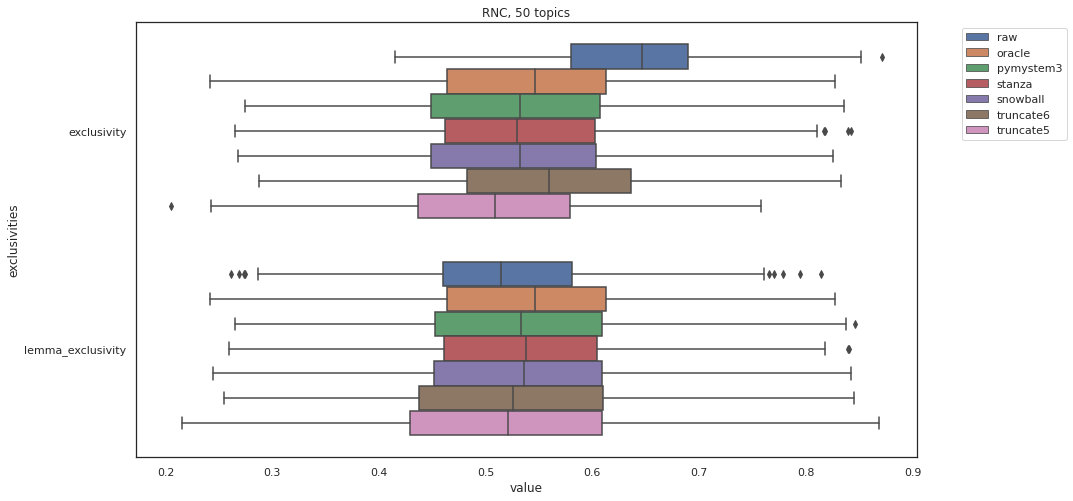

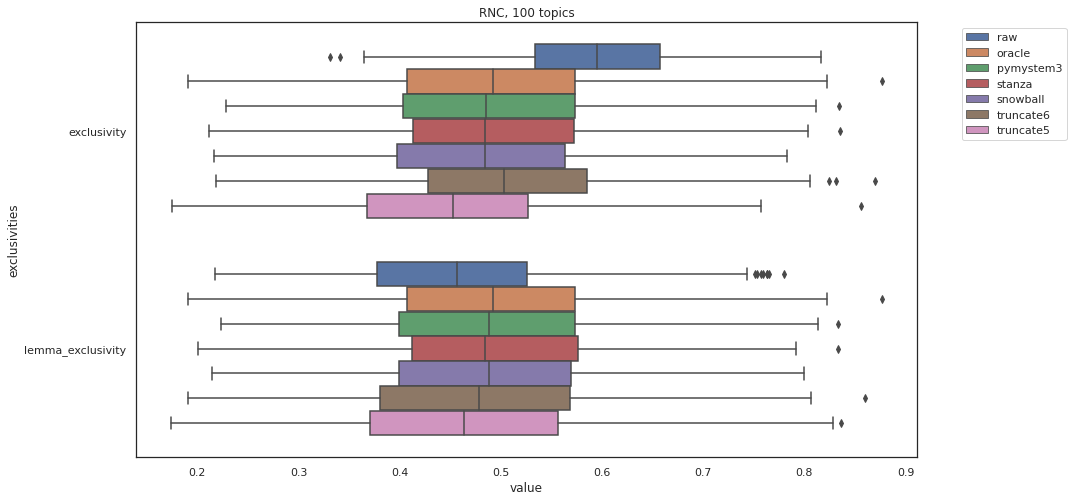

In [24]:
for i, pair in enumerate(num_topics_splits):
    num_topics, df = pair
    plt.figure(i)
    exclusivity_metrics = ['exclusivity', 'lemma_exclusivity']#, 'lemmas_to_top_20_surface_forms', 'slots_to_top_20_surface_forms', 'pos_to_top_20_surface_forms']
    exclusivity_stats = pd.melt(df, "treatment", var_name="exclusivities", value_vars=exclusivity_metrics)

    fig, axs = plt.subplots(figsize=(14, 8))
    sns.boxplot(x="value", y="exclusivities", hue="treatment", data=exclusivity_stats, hue_order=hue_order).set_title(f"{corpus_name.upper()}, {num_topics} topics")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2)

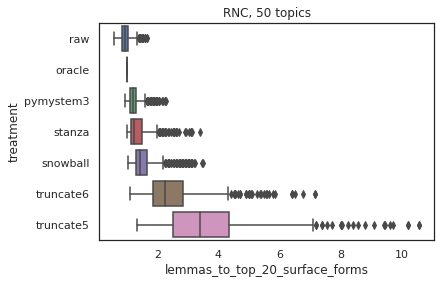

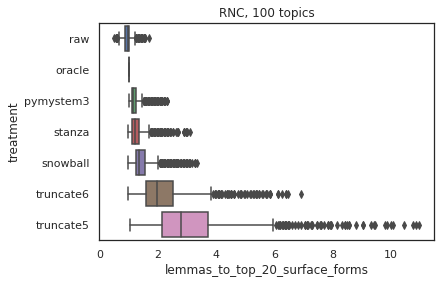

In [25]:
for i, pair in enumerate(num_topics_splits):
    num_topics, df = pair
    plt.figure(i)
    sns.boxplot(x='lemmas_to_top_20_surface_forms', y='treatment', data=df, order=hue_order).set_title(f"{corpus_name.upper()}, {num_topics} topics")

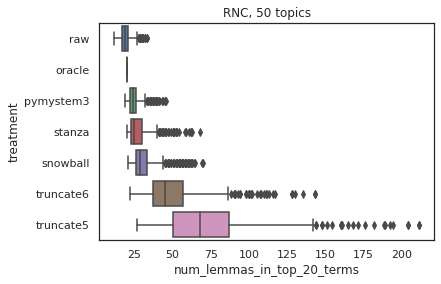

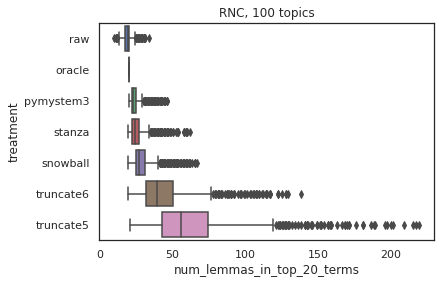

In [26]:
for i, pair in enumerate(num_topics_splits):
    num_topics, df = pair
    plt.figure(i)
    sns.boxplot(x='num_lemmas_in_top_20_terms', y='treatment', data=df, order=hue_order).set_title(f"{corpus_name.upper()}, {num_topics} topics")

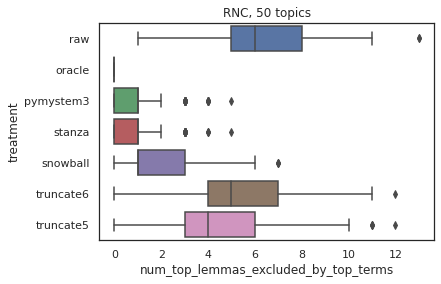

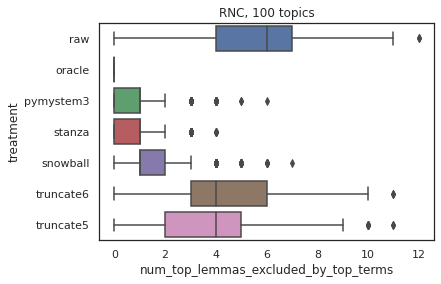

In [27]:
for i, pair in enumerate(num_topics_splits):
    num_topics, df = pair
    plt.figure(i)
    sns.boxplot(x='num_top_lemmas_excluded_by_top_terms', y='treatment', data=df, order=hue_order).set_title(f"{corpus_name.upper()}, {num_topics} topics")

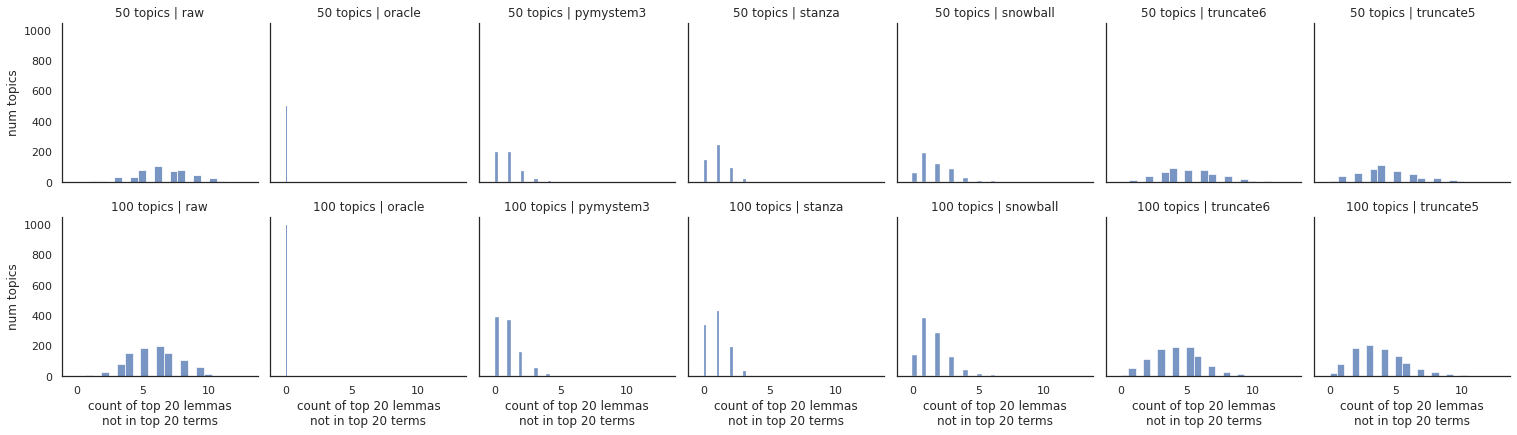

In [28]:
g = sns.FacetGrid(full_frame, col="treatment", row="num_topics", col_order=hue_order)
g.map(sns.histplot, "num_top_lemmas_excluded_by_top_terms", bins=20)
g.set_titles(col_template="{col_name}", row_template= "{row_name} topics")
g.set_axis_labels("count of top 20 lemmas\nnot in top 20 terms", "num topics")

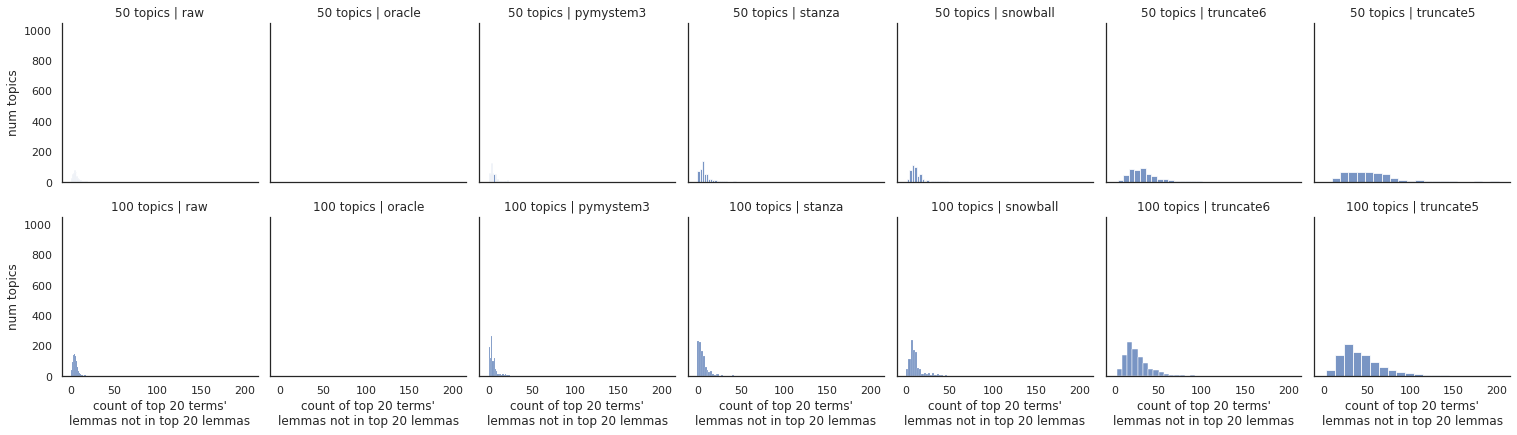

In [29]:
g = sns.FacetGrid(full_frame, col="treatment", row="num_topics", col_order=hue_order)
g.map(sns.histplot, "num_top_term_lemmas_excluded_by_top_lemmas" , bins=20)
g.set_titles(col_template="{col_name}", row_template= "{row_name} topics")
g.set_axis_labels("count of top 20 terms'\nlemmas not in top 20 lemmas", "num topics")

In [38]:
# Visualize the relationships between excluded lemmas and terms
for i, pair in enumerate(num_topics_splits):
    plt.figure(i)
    num_topics, df = pair
    raw_df = df[df["treatment"] == "raw"]
    mean_num_lemmas_excluded = raw_df['num_top_lemmas_excluded_by_top_terms'].mean()
    std_dev = raw_df["num_top_lemmas_excluded_by_top_terms"].std()
    filtered = raw_df[raw_df["num_top_lemmas_excluded_by_top_terms"] >= mean_num_lemmas_excluded + 2*std_dev].sort_values("num_top_lemmas_excluded_by_top_terms", ascending=False)
    print(num_topics, "topic experiments, num_top_lemmas_excluded_by_top_terms, means:", mean_num_lemmas_excluded, "stdev:", std_dev, "count upper end outliers:", len(filtered), "out of", len(raw_df))

    max_top_lemmas_excluded_by_top_terms = raw_df["num_top_lemmas_excluded_by_top_terms"].max()
    print("Max top lemmas excluded by top terms:", max_top_lemmas_excluded_by_top_terms)
    max_top_terms_excluded_by_top_lemmas = raw_df["num_top_term_lemmas_excluded_by_top_lemmas"].max()
    print("Max top term lemmas excluded by top lemmas:", max_top_terms_excluded_by_top_lemmas)

    counts = np.zeros((max_top_lemmas_excluded_by_top_terms +1, max_top_terms_excluded_by_top_lemmas +1))

    for j in range(max_top_lemmas_excluded_by_top_terms + 1):
        for k in range(max_top_terms_excluded_by_top_lemmas + 1):
            counts[j,k] = len(raw_df[(raw_df["num_top_lemmas_excluded_by_top_terms"] == j) & (raw_df['num_top_term_lemmas_excluded_by_top_lemmas']==k)])


    g = sns.heatmap(counts, annot=True, cmap="GnBu")
    g.set(title=f"Counts of topics for {corpus_name.upper()}, {num_topics} experiments", ylabel = "Count of top 20 lemmas excluded\nby top 20 terms", xlabel="Count of lemmas of top 20 terms\nnot in top 20 lemmas")
    
    display(filtered)

50 topic experiments, num_top_lemmas_excluded_by_top_terms, means: 6.436 stdev: 2.0953962323965083 count upper end outliers: 9 out of 500
Max top lemmas excluded by top terms: 13
Max top term lemmas excluded by top lemmas: 21


,topic_id,corpus,treatment,num_topics,experiment_id,tokens,document_entropy,word-length,coherence,uniform_dist,corpus_dist,eff_num_words,token-doc-diff,rank_1_docs,allocation_ratio,allocation_count,exclusivity,negative_coherence,lemma_exclusivity,lemma_entropy,slot_entropy,pos_entropy,lemmas_to_top_20_surface_forms,slots_to_top_20_surface_forms,pos_to_top_20_surface_forms,top_20_term_set,top_20_lemma_set,lemmas_in_top_20_terms,top_lemmas_minus_top_term_lemmas,top_term_lemmas_minus_top_lemmas,num_lemmas_in_top_20_terms,num_top_lemmas_excluded_by_top_terms,num_top_term_lemmas_excluded_by_top_lemmas
2325,25,rnc,raw,50,3,4948.0,2.8805,6.15,-342.2611,3.6482,3.5618,1110.3267,0.0279,0.3393,0.1282,0.3036,0.6696,342.2611,0.6177,10.195600,6.664628,1.724726,0.70,1.20,0.20,сердце ребёнок волос волосы организма мозга кожу таблетки лучше препараты u ребёнку обязательно кожи кожа ребёнка риск препарат минут организм,голова сердце волос малыш нервный мама ребенок гормональный витамин содержать средство реакция процедура кожа препарат таблетка врач рахит гормон организм,лучше препарат таблетка сердце ребенок минута мозг волос u обязательно организм хорошо кожа риск,витамин голова врач рахит мама содержать гормональный гормон малыш средство нервный реакция процедура,лучше минута мозг u обязательно хорошо риск,14,13,7
2945,45,rnc,raw,50,9,3304.0,3.0691,7.25,-298.6142,3.8645,3.9047,916.4218,0.0430,0.1067,0.0000,0.0667,0.6904,298.6142,0.5283,10.091593,7.010871,1.722498,0.65,1.45,0.10,литература мир литературы книги книгу книг автор автора произведения авторы книге стругацких фантастику стихи стругацкие фантастика книга литературе рядом века,литература мир перевод мумия читатель стругацкий писатель век идея литературный автор книжный английский журнал русский текст роман фантастика книга проза,фантастика литература мир стих|стихи произведение книга стих|стих стих автор стихи стругацкий рядом век,книжный роман английский журнал идея перевод мумия литературный читатель русский текст писатель проза,стих|стихи произведение стих|стих стих стихи рядом,13,13,6
1513,13,rnc,raw,50,8,5237.0,3.0017,6.55,-305.6113,3.6133,3.5212,1144.5215,0.0274,0.2879,0.1429,0.2273,0.7036,305.6113,0.6133,10.205799,6.622635,1.717954,0.75,1.30,0.25,препараты кожа средства d кожи волос ребёнок таблетки ребёнка волосы лучше организма беременности мозга организм риск кожу ребёнку средство веществ,кожа мама мозг наркоз месяц рахит волос хорошо процедура витамин нервный содержать малыш организм таблетка гормон препарат ребенок врач средство,организм волос лучше кожа таблетка препарат ребенок мозг средство хорошо d беременность вещество хороший риск,рахит гормон витамин врач мама процедура содержать наркоз малыш месяц нервный,лучше d беременность вещество хороший риск,15,11,6
1872,22,rnc,raw,50,5,17440.0,5.5370,5.20,-318.3601,3.8551,2.2908,584.8163,0.0051,0.0212,0.0000,0.0079,0.5209,318.3601,0.3613,9.890434,6.998214,2.543686,0.90,1.45,0.55,почти теперь первого сразу лишь первой впрочем стал около затем именно году однако никто нового всё-таки года среди годы лет,имя почти два оказаться начало лишь другой российский именно главный год москва однако стать среди первый история прошлый новый последний,новое именно среди год почти первый теперь около все-таки однако лишь затем новый всё-таки сразу никто стать впрочем,имя главный история прошлый два москва начало оказаться российский другой последний,новое впрочем теперь около все-таки сразу никто всё-таки затем,18,11,9
1895,45,rnc,raw,50,5,4396.0,3.0172,5.40,-396.8520,3.7766,3.6675,879.7604,0.0323,0.1846,0.1250,0.1692,0.6525,396.8520,0.5409,10.112220,6.518863,1.835723,0.80,1.25,0.20,растения кожа курс средство хорошо воды гормонов цвет нужно кожи полынь кожу водой волос таблетки волосы можно тел лучше растений,кожа сад телефон растение голова вода уход препарат хорошо вид таблетка почва лист использовать полынь трава процедура крем волос можно,лучше таблетка вода кожа нужно хорошо волос курс телефон полынь можно растение средство цвет горм

100 topic experiments, num_top_lemmas_excluded_by_top_terms, means: 5.769 stdev: 1.942011949090533 count upper end outliers: 23 out of 1000
Max top lemmas excluded by top terms: 12
Max top term lemmas excluded by top lemmas: 20


,topic_id,corpus,treatment,num_topics,experiment_id,tokens,document_entropy,word-length,coherence,uniform_dist,corpus_dist,eff_num_words,token-doc-diff,rank_1_docs,allocation_ratio,allocation_count,exclusivity,negative_coherence,lemma_exclusivity,lemma_entropy,slot_entropy,pos_entropy,lemmas_to_top_20_surface_forms,slots_to_top_20_surface_forms,pos_to_top_20_surface_forms,top_20_term_set,top_20_lemma_set,lemmas_in_top_20_terms,top_lemmas_minus_top_term_lemmas,top_term_lemmas_minus_top_lemmas,num_lemmas_in_top_20_terms,num_top_lemmas_excluded_by_top_terms,num_top_term_lemmas_excluded_by_top_lemmas
2701,1,rnc,raw,100,4,8004.0,4.7798,5.55,-284.4458,4.2814,3.0957,496.8205,0.0025,0.0142,0.0000,0.0036,0.4849,284.4458,0.3056,9.454078,6.702255,2.177527,1.00,1.40,0.35,решил работал рядом однажды друг понял русские перед жизнь слово почти слова стал всё-таки сказал смерти начал русский снова жизни,любить душа рука понять жена друг перед жизнь слово решить любовь новый чувство язык читать отец русский книга снова память,работать ряд все-таки рядом смерть понять однажды друг сказать перед жизнь стать слово почти решить начать начало всё-таки русский снова,душа отец рука читать жена память книга любить любовь новый чувство язык,работать стать начало всё-таки почти однажды ряд все-таки сказать начать рядом смерть,20,12,12
2364,14,rnc,raw,100,1,1614.0,2.4856,6.85,-580.8563,4.5293,4.4576,424.8200,0.0228,0.1429,0.0000,0.0476,0.5526,580.8563,0.4638,9.234645,6.697080,1.677170,0.85,1.40,0.20,домом изделий проекта кв мусор новый доме отходов проект занимается дом год г встречали мусора строительства дома строить переработки строительство,мусор новый печь областной переработка проект материал строитель дом год свалка нижегородский мода отходы построить деревянный строительный архитектор строительство паркет,отходы встречать квартира дома квадратный строительство переработка грамм дом мусор год заниматься изделие домашний строить проект новый,мода деревянный построить печь областной строительный строитель материал архитектор свалка нижегородский паркет,встречать квартира квадратный дома заниматься изделие грамм строить домашний,17,12,9
2874,74,rnc,raw,100,9,8398.0,4.5484,6.40,-255.3277,4.4157,2.9948,436.6473,0.0045,0.0000,0.0000,0.0038,0.3768,255.3277,0.2660,9.180756,6.364596,1.723595,1.30,1.75,0.40,система г работы задачи время д является управления более органов системы связи информации времени управление организации систему работу развития т,подготовка система создание условие форма являться время информация работа новый год основной возможность качество управление обеспечение функция задача различный развитие,система грамм г много являться так дом орган время д далее более информация работа организация год тот доктор город управление то задача связь т тонна развитие,новый подготовка создание условие форма основной возможность качество различный обеспечение функция,орган организация д далее грамм более тонна г много так связь доктор город дом т то тот,26,11,17
1653,3,rnc,raw,100,6,2023.0,2.4268,6.10,-250.5053,4.4621,4.3232,496.8470,0.0337,0.0682,0.0000,0.0455,0.6189,250.5053,0.5255,9.226336,6.798335,1.716527,0.95,1.20,0.20,мамы малыша бывает d малыш аллергии ребёнка лечить обязательно сердца u врачи движений заболевания ребёнок мама ребёнку чаще детей средства,кальций детский продукт болезнь d малыш заболевание ребенок врач аллергический ложка рахит u реакция ребенок|дитя средство молоко мама витамин организм,часто d малыш ребенок|ребенок заболевание ребенок врач лечить обязательно бывать u ребенок|дитя движение|движенье средство мама сердце движение аллергия малыш|малыш,болезнь аллергический кальций витамин детский ложка рахит реакция организм продукт молоко,бывать часто сердце движение аллергия ребенок|ребенок малыш|малыш движение|движенье лечить обязательно,19,11,10
2548,98,rnc,raw,100,3,1173.0,1.7225,7.35,-385.3518,4.5000,4.8903,691.7692,0.0300,0.2333,0.0714,0.0667,0.5541,385.3518,0.5629,9.370399,6.701289,1.645569,0.90,1.15,0.25,разнообразие 

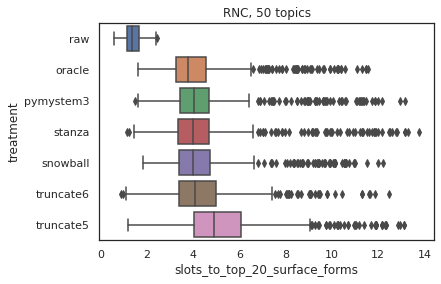

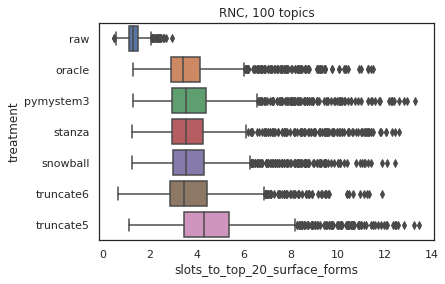

In [31]:
for i, pair in enumerate(num_topics_splits):
    num_topics, df = pair
    plt.figure(i)
    sns.boxplot(x='slots_to_top_20_surface_forms', y='treatment', data=df, order=hue_order).set_title(f"{corpus_name.upper()}, {num_topics} topics")

In [32]:
# Sanity check - oracle exlusivity and oracle post-lemmatize exclusivity should be the same
for i, pair in enumerate(num_topics_splits):
    num_topics, df = pair
    oracle_df = df[df["treatment"] == "oracle"]
    print("Num_topics:", num_topics)
    print("\tOracle exclusivity:", oracle_df['exclusivity'].mean())
    print("\tOracle lemma (post-lemmatize) exclusivity:", oracle_df['lemma_exclusivity'].mean())

Num_topics: 50
	Oracle exclusivity: 0.5384581999999999
	Oracle lemma (post-lemmatize) exclusivity: 0.5384581999999999
Num_topics: 100
	Oracle exclusivity: 0.49285029999999996
	Oracle lemma (post-lemmatize) exclusivity: 0.49285029999999996


# Variation of Information

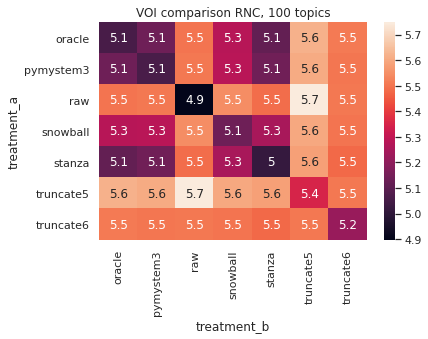

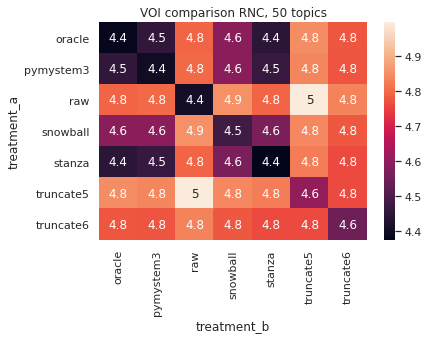

In [33]:
for i, voi in enumerate(voi_folders):
    num_topics = voi.name.split("_")[1]
    voi_frame = parse_voi_directory(voi)
    voi_means = voi_frame.groupby(["treatment_a", "treatment_b"], as_index=False)["voi"].mean()
    voi_means = voi_means.pivot(index="treatment_a", columns="treatment_b", values="voi")
    plt.figure(i)
    sns.heatmap(voi_means, annot=True).set_title(f"VOI comparison {corpus_name.upper()}, {num_topics} topics")


# General diagnostics
These are the standard diagnostics produced by Mallet

In [34]:
full_frame.columns

Index(['topic_id', 'corpus', 'treatment', 'num_topics', 'experiment_id',
       'tokens', 'document_entropy', 'word-length', 'coherence',
       'uniform_dist', 'corpus_dist', 'eff_num_words', 'token-doc-diff',
       'rank_1_docs', 'allocation_ratio', 'allocation_count', 'exclusivity',
       'negative_coherence', 'lemma_exclusivity', 'lemma_entropy',
       'slot_entropy', 'pos_entropy', 'lemmas_to_top_20_surface_forms',
       'slots_to_top_20_surface_forms', 'pos_to_top_20_surface_forms',
       'top_20_term_set', 'top_20_lemma_set', 'lemmas_in_top_20_terms',
       'top_lemmas_minus_top_term_lemmas', 'top_term_lemmas_minus_top_lemmas',
       'num_lemmas_in_top_20_terms', 'num_top_lemmas_excluded_by_top_terms',
       'num_top_term_lemmas_excluded_by_top_lemmas'],
      dtype='object')

<Figure size 432x288 with 0 Axes>

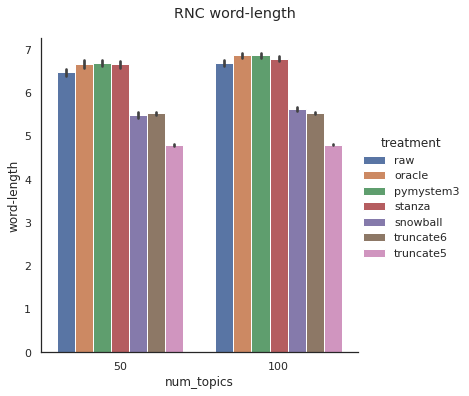

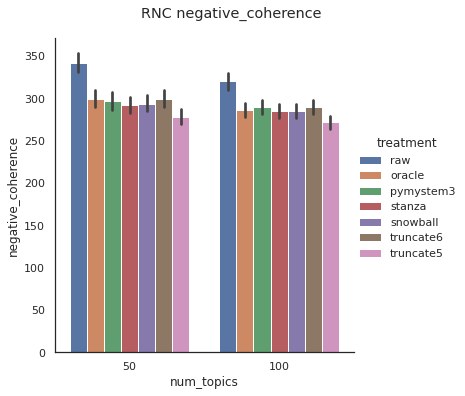

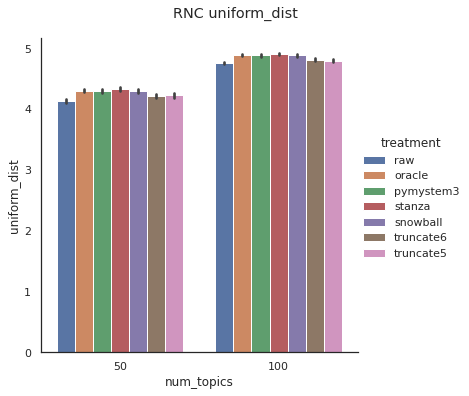

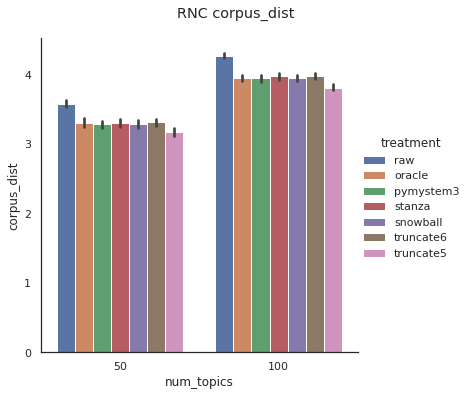

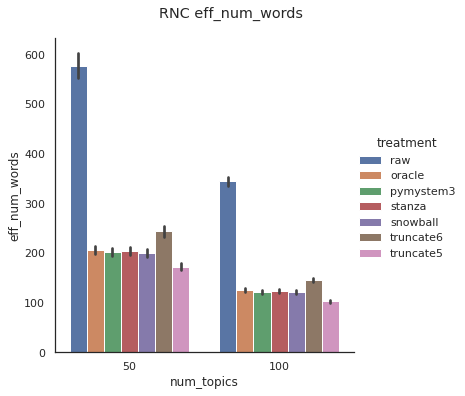

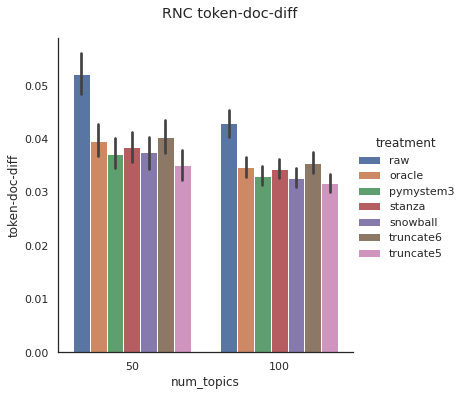

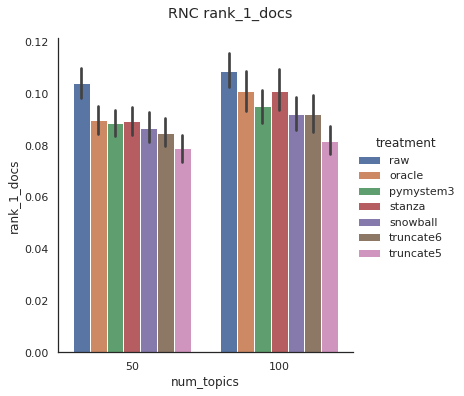

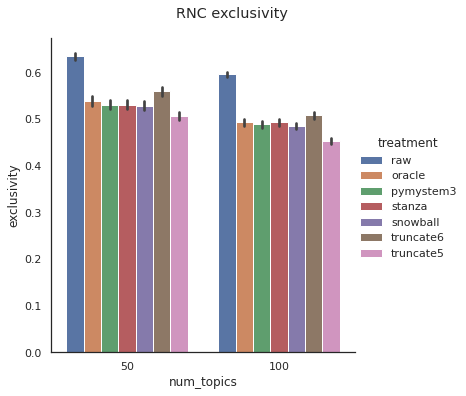

In [35]:
mallet_diagnostics = ['word-length', "negative_coherence", 'uniform_dist', 'corpus_dist', 'eff_num_words', 'token-doc-diff', 'rank_1_docs', 'exclusivity']
for i, m in enumerate(mallet_diagnostics):
    plt.figure(i)
    g = sns.catplot(data = full_frame, kind="bar", x="num_topics", y=m, hue="treatment", hue_order=hue_order)
    g.fig.suptitle(f"{corpus_name.upper()} {m}", y=1.05)
